In [1]:
# automatically apply changes in netgen
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pandas as pd
import numpy as np
import random
import math
from future.utils import listvalues
from copy import deepcopy
import scipy.stats

import cbgt.netgen as ng
import cbgt.generateFrames as gf
#import cbgt.analyzefx as afx
#from cbgt import vis, sim

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline
clrs = ['#347fff', '#febe08']
eclrs = ['#1657de', '#f5a005']

rc = {'font.family': u'sans-serif',
'font.sans-serif': [u'Helvetica',  u'Arial', u'sans-serif'],
'lines.solid_capstyle': u'butt'}
sns.set(style='ticks', font='Helvetica', rc=rc, font_scale=1.4)
# splot.style(theme='safari-day', grid=True, spines=True, fscale=1.4, figsize=(6., 3.5))
# bdf = pd.read_csv("/Users/kyle/demo_cbgt_bdf.csv")

# Specific for the HDDM study
#import hddm

# Save/load datatables functions

In [3]:
# directory = the filepath to where you want to save your data.  
#   You could use directory="" to save it in the same directory 
#   you are running the notebook in.

# foldername = a name for a new folder to put this specific data set in.
#   The code will create this folder for you.  
#   Whenever you have a new data set, you need to use a new foldername, 
#   otherwise it will overwrite the older results.

def saveData(paramtable,datatables,directory,foldername):
    targetfolder = os.path.join(directory,foldername)
    if not os.path.exists(targetfolder):
        os.makedirs(targetfolder)
    file_name = os.path.join(targetfolder,"param.pkl")
    paramtable.to_pickle(file_name,protocol=0)
    for i in range(len(datatables)):
        file_name = os.path.join(targetfolder,"data"+str(i)+".pkl")
        datatables[i].to_pickle(file_name,protocol=0)
        
def loadData(directory,foldername):
    targetfolder = os.path.join(directory,foldername)
    file_name = os.path.join(targetfolder,"param.pkl")
    paramtable = pd.read_pickle(file_name)
    filecount = len([f for f in os.listdir(targetfolder) 
                     if os.path.isfile(os.path.join(targetfolder, f)) 
                     and f.startswith("data") and f.endswith(".pkl")])
    datatables = []
    for i in range(filecount):
        file_name = os.path.join(targetfolder,"data"+str(i)+".pkl")
        datatables.append(pd.read_pickle(file_name))
    return (paramtable,datatables)

# Load data

In [4]:
## load FR and HDDM data

# load CBGT data
targetfolder = os.path.join("","CBGTSolution")
file_name = os.path.join(targetfolder,"CBGTSol.pkl")
FRdatatable = pd.read_pickle(file_name)

# load HDDM data
targetfolder = os.path.join("","hddmSolution")
file_name = os.path.join(targetfolder,"hddmSol.pkl")
hddmSol = pd.read_pickle(file_name)

In [5]:
## load Control Case FR and HDDM data

# load FR data
targetfolder = os.path.join("","CBGTControlCase")
file_name = os.path.join(targetfolder,"CBGTControlCase.pkl")
FRdatatableCC = pd.read_pickle(file_name)

# load HDDM data
targetfolder = os.path.join("","hddmControlCase")
file_name = os.path.join(targetfolder,"hddmControlCase.pkl")
hddmSolCC = pd.read_pickle(file_name)

In [6]:
# Read weights table
import pandas as pd
df = pd.read_csv("weights.csv", 
                  names=["Cx_dMSN_NMDA_L", "Cx_dMSN_NMDA_R", "Cx_iMSN_NMDA_L", "Cx_iMSN_NMDA_R",
                        "Cx_dMSN_AMPA_L", "Cx_dMSN_AMPA_R", "Cx_iMSN_AMPA_L", "Cx_iMSN_AMPA_R",
                         "dMSN_iMSN","D1STR_GPi", "iMSN_dMSN","D2STR_GPe", "GPe_STN","GPe_GPi",
                         "STN_GPi","GPi_Th","Th_STRd", "Th_STRi","Cx_Th","Cx_FSI","STN_GPeA","STN_GPeN",
                         "Th_Cx","GPe_GPe"])
df=df.iloc[1:]
df=df.drop(["dMSN_iMSN","iMSN_dMSN","STN_GPeN","GPe_GPe"], axis=1)

# Set the correct values of the weights (regularizations in the cbgt.c code)
df["Cx_dMSN_NMDA_L"] = 1.5*df["Cx_dMSN_NMDA_L"] 
df["Cx_dMSN_NMDA_R"] = 1.5*df["Cx_dMSN_NMDA_R"]
df["Cx_iMSN_NMDA_L"] = 1.5*df["Cx_iMSN_NMDA_L"]
df["Cx_iMSN_NMDA_R"] = 1.5*df["Cx_iMSN_NMDA_R"]
df["D1STR_GPi"]=1.9*df["D1STR_GPi"]
df["D2STR_GPe"]=(37.0/15.0)*df["D2STR_GPe"]
df["GPe_GPi"]=(10.0/3.0)*df["GPe_GPi"]
df["STN_GPi"]=(10.0/3.0)*df["STN_GPi"]
df["GPi_Th"]=(17.0/6.0)*df["GPi_Th"]
df["Th_STRd"]=1.5*df["Th_STRd"]
df["Th_STRi"]=1.5*df["Th_STRi"]
df["Cx_Th"]=(7.0/6.0)*df["Cx_Th"]
df["Cx_FSI"]=1.5*df["Cx_FSI"]

# A. CCA

In [16]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
import seaborn as sn
import scipy.stats
import statistics
import rcca

### (I) Consider overall activity across channels and difference in activity between channels

##### 1. Firing Rates

In [14]:
X2 = pd.DataFrame()
X2['FSI'] = FRdatatable['msd_FSI_0']
X2['LIPI'] = FRdatatable['msd_LIPI_0']
for pop in ['GPi','STNE','GPeP','D1STR','D2STR','LIP','Th']:
    X2[pop+'_sum'] = FRdatatable['msd_'+pop+'_0_0'] + FRdatatable['msd_'+pop+'_1_0']
for pop in ['GPi','STNE','GPeP','D1STR','D2STR','LIP','Th']:
    X2[pop+'_diff'] = FRdatatable['msd_'+pop+'_0_0'] - FRdatatable['msd_'+pop+'_1_0']

##### 2. Weights

In [15]:
df2 = pd.DataFrame()
df2['Cx_dMSN_NMDA_sum'] = df['Cx_dMSN_NMDA_L']+df['Cx_dMSN_NMDA_R']
df2['Cx_dMSN_NMDA_diff'] = df['Cx_dMSN_NMDA_L']-df['Cx_dMSN_NMDA_R']
df2['Cx_iMSN_NMDA_sum'] = df['Cx_iMSN_NMDA_L']+df['Cx_iMSN_NMDA_R']
df2['Cx_iMSN_NMDA_diff'] = df['Cx_iMSN_NMDA_L']-df['Cx_iMSN_NMDA_R']


df2['Cx_dMSN_AMPA_sum'] = df['Cx_dMSN_AMPA_L']+df['Cx_dMSN_AMPA_R']
df2['Cx_dMSN_AMPA_diff'] = df['Cx_dMSN_AMPA_L']-df['Cx_dMSN_AMPA_R']
df2['Cx_iMSN_AMPA_sum'] = df['Cx_iMSN_AMPA_L']+df['Cx_iMSN_AMPA_R']
df2['Cx_iMSN_AMPA_diff'] = df['Cx_iMSN_AMPA_L']-df['Cx_iMSN_AMPA_R']

#df2['dMSN_iMSN'] = df['dMSN_iMSN']
df2['D1STR_GPi'] = df['D1STR_GPi']
#df2['iMSN_dMSN'] = df['iMSN_dMSN']
df2['D2STR_GPe'] = df['D2STR_GPe']
df2['GPe_STN'] = df['GPe_STN']
df2['GPe_GPi'] = df['GPe_GPi']
df2['STN_GPi'] = df['STN_GPi']
df2['GPi_Th'] = df['GPi_Th']
df2['Th_STRd'] = df['Th_STRd']
df2['Th_STRi'] = df['Th_STRi']
df2['Cx_Th'] = df['Cx_Th']

df2['Cx_FSI'] = df['Cx_FSI']
df2['STN_GPeA'] = df['STN_GPeA']
#df2['STN_GPeN'] = df['STN_GPeN']
df2['Th_Cx'] = df['Th_Cx']
#df2['GPe_GPe'] = df['GPe_GPe']

### (II) Choose a specific case to study

##### 1. FR - HDDM case (execute only if you want to consider this case)

In [10]:
# FR-HDDM

#case='_FD_X2'#addsub'
#case='_DF'
case='_FD_X2_2'


# Select the columns we want from FRdatatable
#X = pd.DataFrame(FRdatatable,columns=['msd_FSI_0','msd_LIPI_0','msd_GPi_0_0','msd_GPi_1_0','msd_STNE_0_0','msd_STNE_1_0','msd_GPeP_0_0','msd_GPeP_1_0','msd_D1STR_0_0','msd_D1STR_1_0','msd_D2STR_0_0','msd_D2STR_1_0','msd_LIP_0_0','msd_LIP_1_0','msd_Th_0_0','msd_Th_1_0'])
X=X2

# Select the columns we want from hddmSol
Y = pd.DataFrame(hddmSol,columns=['mean_a','mean_v','mean_t','mean_z'])

#name_u=['msd_FSI_0','msd_LIPI_0','msd_GPi_0_0','msd_GPi_1_0','msd_STNE_0_0','msd_STNE_1_0','msd_GPeP_0_0','msd_GPeP_1_0','msd_D1STR_0_0','msd_D1STR_1_0','msd_D2STR_0_0','msd_D2STR_1_0','msd_LIP_0_0','msd_LIP_1_0','msd_Th_0_0','msd_Th_1_0']
#name_u=['FSI','LIPI','GPi_sum','STNE_sum','GPeP_sum','D1STR_sum','D2STR_sum','LIP_sum','Th_sum','GPi_diff','STNE_diff','GPeP_diff','D1STR_diff','D2STR_diff','LIP_diff','Th_diff']
name_u=['FSI','CxI','GPi_sum','STN_sum','GPe_sum','dSPN_sum','iSPN_sum','Cx_sum','Th_sum','GPi_diff','STN_diff','GPe_diff','dSPN_diff','iSPN_diff','Cx_diff','Th_diff']
#name_v=['mean_a','mean_v','mean_t','mean_z']
name_v=['a','v','t','z']

#CVA parameters
SplitsKfold=4

#CVA-CCA comparison parameters (to check the number of components we want to use)
maxComp=int(min(X.size/len(X),Y.size/len(Y)))   # 4
print(maxComp)

#Number of components we want to use
RequiredComponents=3

4


##### 2. Weights -  FR case  (execute only if you want to consider this case)

In [17]:
# Weights - HDDM

case='_wF_X2df2'

# Select the columns we want from weights
#X = df
X=df2
# Select the columns we want from FRdatatable
#Y = pd.DataFrame(FRdatatable,columns=['msd_FSI_0','msd_LIPI_0','msd_GPi_0_0','msd_GPi_1_0','msd_STNE_0_0','msd_STNE_1_0','msd_GPeP_0_0','msd_GPeP_1_0','msd_D1STR_0_0','msd_D1STR_1_0','msd_D2STR_0_0','msd_D2STR_1_0','msd_LIP_0_0','msd_LIP_1_0','msd_Th_0_0','msd_Th_1_0'])
Y=X2

#name_u=['w_Cx_dMSN_NMDA_L', 'w_Cx_dMSN_NMDA_R', 'w_Cx_iMSN_NMDA_L', 'w_Cx_iMSN_NMDA_R', 'w_Cx_dMSN_AMPA_L', 'w_Cx_dMSN_AMPA_R', 'x_Cx_iMSN_AMPA_L', 'w_Cx_iMSN_AMPA_R','w_D1STR_GPi','w_D2STR_GPe', 'w_GPe_STN','w_GPe_GPi','w_STN_GPi','w_GPi_Th','w_Th_STRd', 'w_Th_STRi','w_Cx_Th','w_Cx_FSI','w_STN_GPeA','w_Th_Cx']

#name_u=['w_Cx_dMSN_NMDA_sum', 'w_Cx_dMSN_NMDA_diff', 'w_Cx_iMSN_NMDA_sum', 'w_Cx_iMSN_NMDA_diff', 'w_Cx_dMSN_AMPA_sum', 'w_Cx_dMSN_AMPA_diff', 'x_Cx_iMSN_AMPA_sum', 'w_Cx_iMSN_AMPA_diff','w_D1STR_GPi','w_D2STR_GPe', 'w_GPe_STN','w_GPe_GPi','w_STN_GPi','w_GPi_Th','w_Th_STRd', 'w_Th_STRi','w_Cx_Th','w_Cx_FSI','w_STN_GPeA','w_Th_Cx']
#name_v=['msd_FSI_0','msd_LIPI_0','msd_GPi_0_0','msd_GPi_1_0','msd_STNE_0_0','msd_STNE_1_0','msd_GPeP_0_0','msd_GPeP_1_0','msd_D1STR_0_0','msd_D1STR_1_0','msd_D2STR_0_0','msd_D2STR_1_0','msd_LIP_0_0','msd_LIP_1_0','msd_Th_0_0','msd_Th_1_0']
#name_v=['FSI','LIPI','GPi_sum','STNE_sum','GPeP_sum','D1STR_sum','D2STR_sum','LIP_sum','Th_sum','GPi_diff','STNE_diff','GPeP_diff','D1STR_diff','D2STR_diff','LIP_diff','Th_diff']

name_u=['w_Cx_dSPN_NMDA_sum', 'w_Cx_dSPN_NMDA_diff', 'w_Cx_iSPN_NMDA_sum', 'w_Cx_iSPN_NMDA_diff', 'w_Cx_dSPN_AMPA_sum', 'w_Cx_dSPN_AMPA_diff', 'w_Cx_iSPN_AMPA_sum', 'w_Cx_iSPN_AMPA_diff','w_dSPN_GPi','w_iSPN_GPe', 'w_GPe_STN','w_GPe_GPi','w_STN_GPi','w_GPi_Th','w_Th_dSPN', 'w_Th_iSPN','w_Cx_Th','w_Cx_FSI','w_STN_GPe_AMPA','w_Th_Cx']
name_v=['FSI','CxI','GPi_sum','STN_sum','GPe_sum','dSPN_sum','iSPN_sum','Cx_sum','Th_sum','GPi_diff','STN_diff','GPe_diff','dSPN_diff','iSPN_diff','Cx_diff','Th_diff']

#CVA parameters
SplitsKfold=4

#CVA-CCA comparison parameters (to check the number of components we want to use)
maxComp=int(min(X.size/len(X),Y.size/len(Y)))  # 16
print(maxComp)

#Number of components we want to use
RequiredComponents=3


16


##### 3. Weights - DDM case  (execute only if you want to consider this case)

In [97]:
# Weights - HDDM

case='_wF_DDM'

# Select the columns we want from weights
#X = df
X=df2
# Select the columns we want from HDDMsol
Y = pd.DataFrame(hddmSol,columns=['mean_a','mean_v','mean_t','mean_z'])

#name_u=['w_Cx_dMSN_NMDA_sum', 'w_Cx_dMSN_NMDA_diff', 'w_Cx_iMSN_NMDA_sum', 'w_Cx_iMSN_NMDA_diff', 'w_Cx_dMSN_AMPA_sum', 'w_Cx_dMSN_AMPA_diff', 'x_Cx_iMSN_AMPA_sum', 'w_Cx_iMSN_AMPA_diff','w_D1STR_GPi','w_D2STR_GPe', 'w_GPe_STN','w_GPe_GPi','w_STN_GPi','w_GPi_Th','w_Th_STRd', 'w_Th_STRi','w_Cx_Th','w_Cx_FSI','w_STN_GPeA','w_Th_Cx']
#name_v=['mean_a','mean_v','mean_t','mean_z']
name_u=['w_Cx_dMSN_NMDA_sum', 'w_Cx_dMSN_NMDA_diff', 'w_Cx_iMSN_NMDA_sum', 'w_Cx_iMSN_NMDA_diff', 'w_Cx_dMSN_AMPA_sum', 'w_Cx_dMSN_AMPA_diff', 'x_Cx_iMSN_AMPA_sum', 'w_Cx_iMSN_AMPA_diff','w_dMSN_GPi','w_iMSN_GPe', 'w_GPe_STN','w_GPe_GPi','w_STN_GPi','w_GPi_Th','w_Th_dMSN', 'w_Th_iMSN','w_Cx_Th','w_Cx_FSI','w_STN_GPe_AMPA','w_Th_Cx']
name_v=['a','v','t','z']




#CVA parameters
SplitsKfold=8

#CVA-CCA comparison parameters (to check the number of components we want to use)
maxComp=int(min(X.size/len(X),Y.size/len(Y)))  # 16
print(maxComp)

#Number of components we want to use
RequiredComponents=3



4


# (III) Perform the study

## 1. Study the number of components for the CCA (Cross-Validation Analysis)

[0.06970335039958213, 0.14514221899988433, 0.20805673491942114, 0.04594161733917746, -0.16149025414551085, -0.2245071263936657, -0.19347793962479135, -0.13886741494897695, -0.3165639977715962, -0.5116763225572936, -0.6091635037465957, -0.6963977940120337, -0.8412949164705505, -0.9146707750021144, -1.0277446609691845, -1.0718199764360832]
[0.03037200809787036, 0.05238483191179358, 0.05033042267786325, 0.06233812122909815, 0.18660098959876636, 0.23124154041328393, 0.2140701728383386, 0.2114513471389921, 0.25109554404988577, 0.28384139449458934, 0.3139892755050696, 0.33015725800765267, 0.3835759850833324, 0.37064756497657136, 0.4328938569548669, 0.4313789854185749]


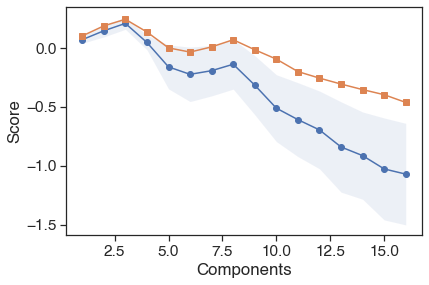

In [18]:
# No Cross Validation
score=[]
NumComp=[]
for n_comp in range(1,maxComp+1):
    cca = CCA(n_components=n_comp)#,scale=False)
    cca.fit(X, Y) #--> Fit model to data

    Xu, Yv = cca.transform(X, Y) #--> Apply the dimension reduction learned on the train data
    score.append(cca.score(X,Y))
    NumComp.append(n_comp)


# Cross-Validation
kf = KFold(n_splits=SplitsKfold)
posX=[]
scoresMeanCV=[]
scoresStdCV=[]

totalSubjects=300
for i in range(0,totalSubjects):
    posX.append(str(i))


for n_comp in range(1,maxComp+1):
    scoresAux=[]
    for train, test in kf.split(posX):
        X_train=X.loc[train,:]
        Y_train=Y.loc[train,:]
        X_test=X.loc[test,:]
        Y_test=Y.loc[test,:]
    
        # Compute U=Xu and V=Yv for the specific train/test data
        cca = CCA(n_components=n_comp)
        cca.fit(X_train, Y_train) #--> Fit model to data
        Xu, Yv = cca.transform(X_test, Y_test)
        scoresAux.append(cca.score(X_test,Y_test))
    scoresMeanCV.append(statistics.mean(scoresAux))
    scoresStdCV.append(statistics.stdev(scoresAux))
    

print(scoresMeanCV)
print(scoresStdCV)

fig = plt.figure()
plt.plot(NumComp,scoresMeanCV,marker="o")
plt.fill_between(NumComp,np.subtract(scoresMeanCV,scoresStdCV),np.add(scoresMeanCV,scoresStdCV),alpha=.1)
plt.plot(NumComp,score,marker="s")
plt.tight_layout()
plt.xlabel("Components")
plt.ylabel("Score")
plt.show()
figName='CCA_NumComp'+case+'.png'
fig.savefig(figName, dpi=400)

## 2. CCA using the full data (no cross-validation analysisi - CVA)

Correlation Coeficient per each component:  [0.99748402 0.99945594 0.9904247 ]
CCA parameters: {'copy': True, 'max_iter': 500, 'n_components': 3, 'scale': True, 'tol': 1e-06}
CCA score from score function: 0.2428663732099265


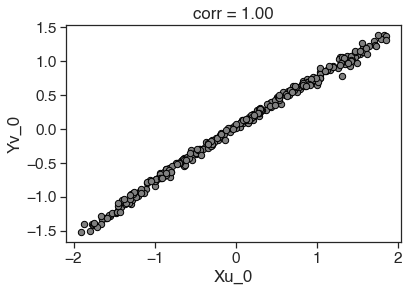

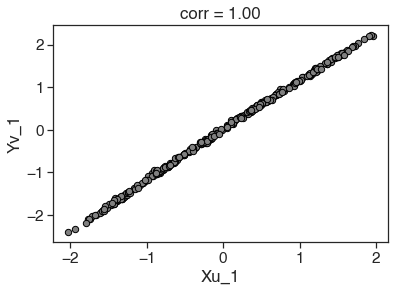

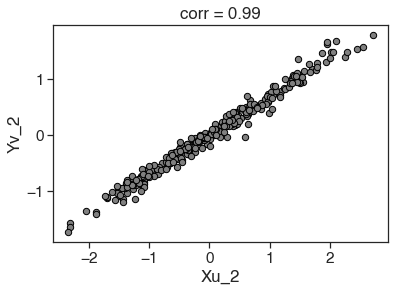

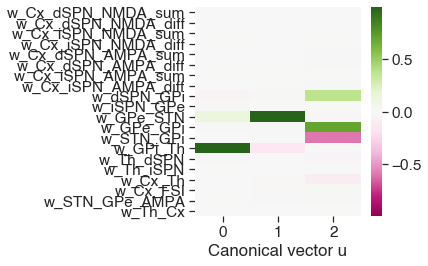

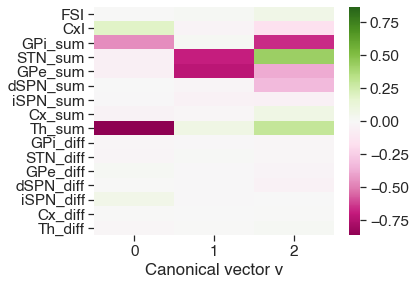

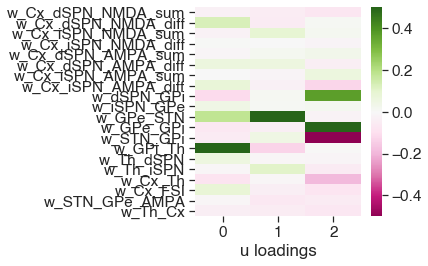

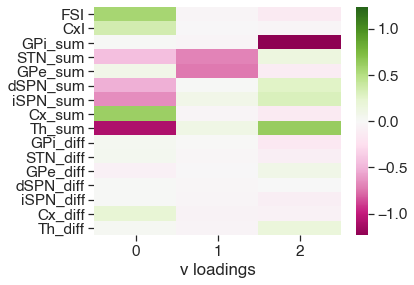

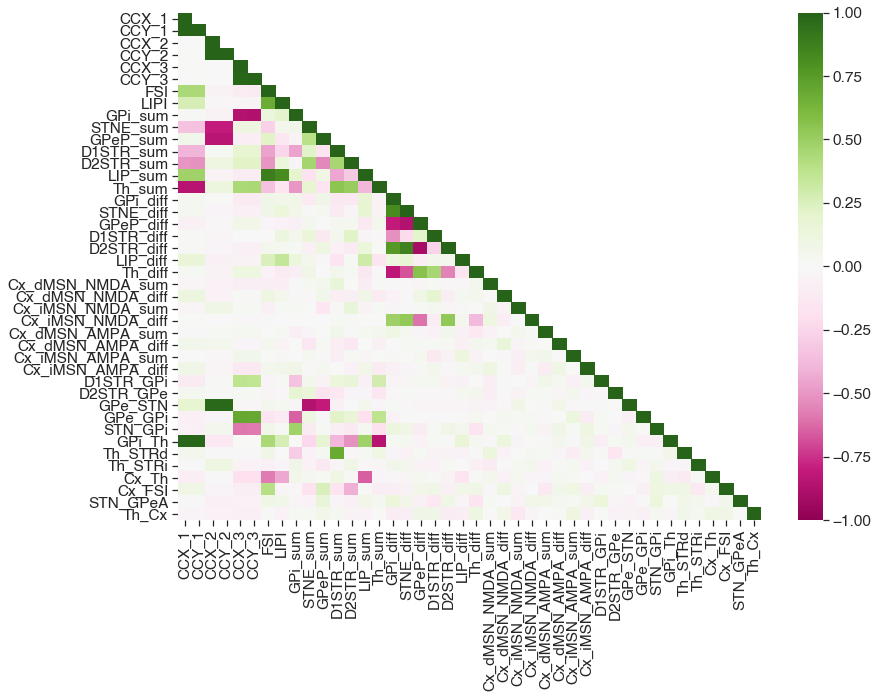

In [19]:
#Standardize the variables
X=(X-X.mean())/(X.std())
Y=(Y-Y.mean())/(Y.std())

#Compute the CCA
cca = CCA(n_components=RequiredComponents)#,scale=False)
cca.fit(X, Y) #--> Fit model to data

Xu, Yv = cca.transform(X, Y) #--> Apply the dimension reduction learned on the train data


#Compute Scores
Correlation = np.diag(np.corrcoef(cca.x_scores_, cca.y_scores_, rowvar=False)[:RequiredComponents,RequiredComponents:])
print('Correlation Coeficient per each component: ',Correlation)

score = np.corrcoef(Xu.T,Yv.T).diagonal(offset=RequiredComponents)
print('CCA parameters:',cca.get_params())
print('CCA score from score function:',cca.score(X,Y))#,Yv[:,3]))


# PLOTS
for i in range(0,RequiredComponents):
    fig = plt.figure()
    plt.scatter(Xu[:, i], Yv[:, i], s=40, c='gray', edgecolors=(0, 0, 0))
    xl="Xu_"+str(i)
    yl="Yv_"+str(i)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title('corr = %.2f' %
              np.corrcoef(Xu[:, i], Yv[:, i])[0, 1])
    FigName='cca_scatterPlot-Comp'+str(i)+'.png'
    #fig.savefig(FigName, dpi=400)

#U=Xu.T@X
#V=Yv.T@Y
u=cca.x_weights_
v=cca.y_weights_
u=pd.DataFrame(u)
v=pd.DataFrame(v)

u.index=name_u
v.index=name_v



#Loadings
uload=cca.x_loadings_
vload=cca.y_loadings_
uload=pd.DataFrame(uload)
vload=pd.DataFrame(vload)

uload.index=name_u
vload.index=name_v



## CANONICAL VECTORS

import matplotlib.colors as colors

# PLOT canonical vector U
cm = plt.cm.get_cmap('PiYG')
fig = plt.figure()
vmax = abs(u).max().max()
vmin = -vmax
#norm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
sn.heatmap(u, yticklabels=True, cmap=cm, vmin=vmin, vmax=vmax)#, annot=False)
#plt.ylabel("CBGT variables")
plt.xlabel("Canonical vector u")
plt.tight_layout()
plt.show()
figName='cca_U'+case+'.png'
fig.savefig(figName, dpi=400)


# PLOT canonical vector V
cm = plt.cm.get_cmap('PiYG')
fig = plt.figure()
vmax = abs(v).max().max()
vmin = -vmax
#norm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
sn.heatmap(v, yticklabels=True, cmap=cm, vmin=vmin, vmax=vmax)#, annot=False)
plt.tight_layout()
#plt.ylabel("HDDM variables")
plt.xlabel("Canonical vector v")
plt.show()
figName='cca_V'+case+'.png'
fig.savefig(figName, dpi=400)



# PLOT loading vector U
cm = plt.cm.get_cmap('PiYG')
fig = plt.figure()
vmax = 0.5 #abs(uload).max().max()
vmin = -vmax
#norm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
sn.heatmap(uload, yticklabels=True, cmap=cm, vmin=vmin, vmax=vmax)#, annot=False)
#plt.ylabel("CBGT variables")
plt.xlabel("u loadings")
plt.tight_layout()
plt.show()
figName='cca_Uloading'+case+'.png'
fig.savefig(figName, dpi=400)


# PLOT loading vector V
cm = plt.cm.get_cmap('PiYG')
fig = plt.figure()
vmax = abs(vload).max().max()
vmin = -vmax
#norm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
sn.heatmap(vload, yticklabels=True, cmap=cm, vmin=vmin, vmax=vmax)#, annot=False)
plt.tight_layout()
#plt.ylabel("HDDM variables")
plt.xlabel("v loadings")
plt.show()
figName='cca_Vloading'+case+'.png'
fig.savefig(figName, dpi=400)



## PLOT correlations: 
# Add CCA results with the X data
cc_res = pd.DataFrame({"CCX_1":Xu[:,0],"CCY_1":Yv[:,0],
                       "CCX_2":Xu[:,1],"CCY_2":Yv[:,1],
                       "CCX_3":Xu[:,2],"CCY_3":Yv[:,2], 
                       #"CCX_4":Xu[:,3],"CCY_4":Yv[:,3],
                      })

cc_res = pd.concat([cc_res, Y], axis=1)
cc_res = pd.concat([cc_res, X], axis=1)


# plot
corrMatrix = cc_res.corr(method='pearson')
vmax = abs(corrMatrix).max().max()
vmin = -vmax
cm = plt.cm.get_cmap('PiYG')
fig = plt.figure(figsize=(13,10))
corrMatrixPlot = corrMatrix.where(np.tril(np.ones(corrMatrix.shape)).astype(np.bool))
sn.heatmap(corrMatrixPlot,yticklabels=True,xticklabels=True,vmax=vmax,vmin=vmin, cmap=cm)
plt.tight_layout()
plt.show()
figName='cca_Correlations'+case+'.png'
fig.savefig(figName, dpi=400)




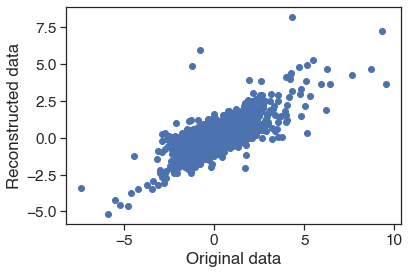

In [95]:
Xinv = cca.inverse_transform(Xu)
Xinv= pd.DataFrame(Xinv)
fig = plt.figure()
plt.scatter(X, Xinv)
plt.xlabel('Original data')
plt.ylabel('Reconstructed data')

FigName='CCAinverseTransform'+case+'_X.png'
fig.savefig(FigName, dpi=400)

## 3. Previous study separating Cx-SPN from the rest

In [16]:
# Weights - FR: Cx-MSN

case='_wCxMSN_FR'

# Select the columns we want from weights
X = pd.DataFrame(df,columns=['Cx_dMSN_NMDA_L', 'Cx_dMSN_NMDA_R', 'Cx_iMSN_NMDA_L', 'Cx_iMSN_NMDA_R', 'Cx_dMSN_AMPA_L', 'Cx_dMSN_AMPA_R', 'Cx_iMSN_AMPA_L', 'Cx_iMSN_AMPA_R'])
#Y = pd.DataFrame(FRdatatable,columns=['msd_FSI_0','msd_LIPI_0','msd_GPi_0_0','msd_GPi_1_0','msd_STNE_0_0','msd_STNE_1_0','msd_GPeP_0_0','msd_GPeP_1_0','msd_D1STR_0_0','msd_D1STR_1_0','msd_D2STR_0_0','msd_D2STR_1_0','msd_LIP_0_0','msd_LIP_1_0','msd_Th_0_0','msd_Th_1_0'])

name_u=['w_Cx_dSPN_NMDA_L', 'w_Cx_dSPN_NMDA_R', 'w_Cx_iSPN_NMDA_L', 'w_Cx_iSPN_NMDA_R', 'w_Cx_dSPN_AMPA_L', 'w_Cx_dSPN_AMPA_R', 'w_Cx_iSPN_AMPA_L', 'w_Cx_iSPN_AMPA_R']
#name_v=['msd_FSI_0','msd_LIPI_0','msd_GPi_0_0','msd_GPi_1_0','msd_STNE_0_0','msd_STNE_1_0','msd_GPeP_0_0','msd_GPeP_1_0','msd_D1STR_0_0','msd_D1STR_1_0','msd_D2STR_0_0','msd_D2STR_1_0','msd_LIP_0_0','msd_LIP_1_0','msd_Th_0_0','msd_Th_1_0']



# SUM/DIFF CASE
#X = pd.DataFrame(df2,columns=['Cx_dMSN_NMDA_sum', 'Cx_dMSN_NMDA_diff', 'Cx_iMSN_NMDA_sum', 'Cx_iMSN_NMDA_diff', 'Cx_dMSN_AMPA_sum', 'Cx_dMSN_AMPA_diff', 'Cx_iMSN_AMPA_sum', 'Cx_iMSN_AMPA_diff'])
Y=X2

#name_u=['w_Cx_dMSN_NMDA_sum', 'w_Cx_dMSN_NMDA_diff', 'w_Cx_iMSN_NMDA_sum', 'w_Cx_iMSN_NMDA_diff', 'w_Cx_dMSN_AMPA_sum', 'w_Cx_dMSN_AMPA_diff', 'w_Cx_iMSN_AMPA_sum', 'w_Cx_iMSN_AMPA_diff']
name_v=['FSI','CxI','GPi_sum','STN_sum','GPe_sum','dSPN_sum','iSPN_sum','Cx_sum','Th_sum','GPi_diff','STN_diff','GPe_diff','dSPN_diff','iSPN_diff','Cx_diff','Th_diff']

#CVA parameters
SplitsKfold=4

#CVA-CCA comparison parameters (to check the number of components we want to use)
maxComp=int(min(X.size/len(X),Y.size/len(Y)))  # 16
print(maxComp)

#Number of components we want to use
RequiredComponents=1

8


In [15]:
# Weights - FR: rest of them

case='_wRestofThem_FR'



# Select the columns we want from weights
X = pd.DataFrame(df,columns=['D1STR_GPi','D2STR_GPe', 'GPe_STN','GPe_GPi','STN_GPi','GPi_Th','Th_STRd', 'Th_STRi','Cx_Th','Cx_FSI','STN_GPeA','Th_Cx'])
Y = pd.DataFrame(FRdatatable,columns=['msd_FSI_0','msd_LIPI_0','msd_GPi_0_0','msd_GPi_1_0','msd_STNE_0_0','msd_STNE_1_0','msd_GPeP_0_0','msd_GPeP_1_0','msd_D1STR_0_0','msd_D1STR_1_0','msd_D2STR_0_0','msd_D2STR_1_0','msd_LIP_0_0','msd_LIP_1_0','msd_Th_0_0','msd_Th_1_0'])

name_u=['w_D1STR_GPi','w_D2STR_GPe', 'w_GPe_STN','w_GPe_GPi','w_STN_GPi','w_GPi_Th','w_Th_STRd', 'w_Th_STRi','w_Cx_Th','w_Cx_FSI','w_STN_GPeA','w_Th_Cx']
name_v=['msd_FSI_0','msd_LIPI_0','msd_GPi_0_0','msd_GPi_1_0','msd_STNE_0_0','msd_STNE_1_0','msd_GPeP_0_0','msd_GPeP_1_0','msd_D1STR_0_0','msd_D1STR_1_0','msd_D2STR_0_0','msd_D2STR_1_0','msd_LIP_0_0','msd_LIP_1_0','msd_Th_0_0','msd_Th_1_0']



# SUM/DIFF CASE
#X=df2
#X = pd.DataFrame(df2,columns=['D1STR_GPi','D2STR_GPe', 'GPe_STN','GPe_GPi','STN_GPi','GPi_Th','Th_STRd', 'Th_STRi','Cx_Th','Cx_FSI','STN_GPeA','Th_Cx'])
#Y=X2

name_u=['w_D1STR_GPi','w_D2STR_GPe', 'w_GPe_STN','w_GPe_GPi','w_STN_GPi','w_GPi_Th','w_Th_STRd', 'w_Th_STRi','w_Cx_Th','w_Cx_FSI','w_STN_GPeA','w_Th_Cx']
name_v=['FSI','LIPI','GPi_sum','STNE_sum','GPeP_sum','D1STR_sum','D2STR_sum','LIP_sum','Th_sum','GPi_diff','STNE_diff','GPeP_diff','D1STR_diff','D2STR_diff','LIP_diff','Th_diff']

#CVA parameters
SplitsKfold=4

#CVA-CCA comparison parameters (to check the number of components we want to use)
maxComp=int(min(X.size/len(X),Y.size/len(Y)))  # 16
print(maxComp)

#Number of components we want to use
RequiredComponents=3

12


[-0.04957519281932468, -0.3010017485222053, -0.6815755776945553, -1.1155456010092755, -1.3906464628228776, -1.660996672790817, -1.840636348538766, -1.9979406514958071]
[0.050274093496474645, 0.1374954612452247, 0.48463875699523534, 0.667714930317257, 0.7349231849878132, 0.6945603132489784, 0.653496340627605, 0.6942761689191942]


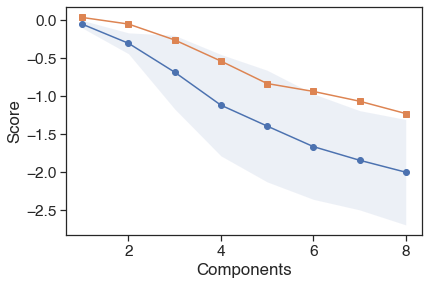

In [11]:
# No Cross Validation
score=[]
NumComp=[]
for n_comp in range(1,maxComp+1):
    cca = CCA(n_components=n_comp)#,scale=False)
    cca.fit(X, Y) #--> Fit model to data

    Xu, Yv = cca.transform(X, Y) #--> Apply the dimension reduction learned on the train data
    score.append(cca.score(X,Y))
    NumComp.append(n_comp)


# Cross-Validation
kf = KFold(n_splits=SplitsKfold)
posX=[]
scoresMeanCV=[]
scoresStdCV=[]

totalSubjects=300
for i in range(0,totalSubjects):
    posX.append(str(i))


for n_comp in range(1,maxComp+1):
    scoresAux=[]
    for train, test in kf.split(posX):
        X_train=X.loc[train,:]
        Y_train=Y.loc[train,:]
        X_test=X.loc[test,:]
        Y_test=Y.loc[test,:]
    
        # Compute U=Xu and V=Yv for the specific train/test data
        cca = CCA(n_components=n_comp)
        cca.fit(X_train, Y_train) #--> Fit model to data
        Xu, Yv = cca.transform(X_test, Y_test)
        scoresAux.append(cca.score(X_test,Y_test))
    scoresMeanCV.append(statistics.mean(scoresAux))
    scoresStdCV.append(statistics.stdev(scoresAux))
    
print(scoresMeanCV)
print(scoresStdCV)

fig = plt.figure()
plt.plot(NumComp,scoresMeanCV,marker="o")
plt.fill_between(NumComp,np.subtract(scoresMeanCV,scoresStdCV),np.add(scoresMeanCV,scoresStdCV),alpha=.1)
plt.plot(NumComp,score,marker="s")
plt.tight_layout()
plt.xlabel("Components")
plt.ylabel("Score")
plt.show()
figName='CCA_NumComp'+case+'.png'
fig.savefig(figName, dpi=400)

Correlation Coeficient per each component:  [0.63085225]
CCA parameters: {'copy': True, 'max_iter': 500, 'n_components': 1, 'scale': True, 'tol': 1e-06}
CCA score from score function: 0.03875905649273253


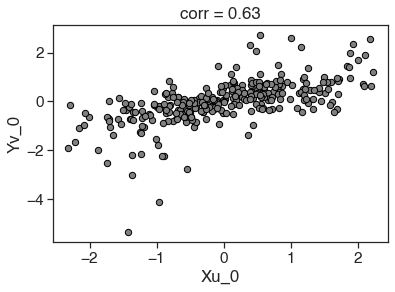

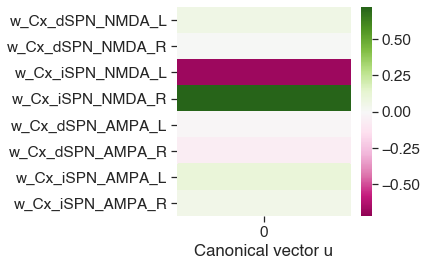

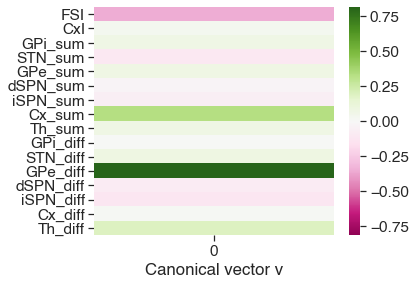

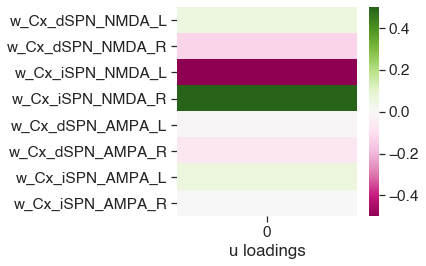

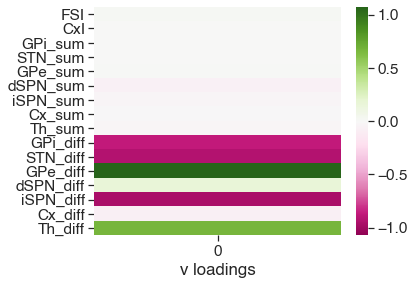

In [17]:
#Standardize the variables
X=(X-X.mean())/(X.std())
Y=(Y-Y.mean())/(Y.std())

#Compute the CCA
cca = CCA(n_components=RequiredComponents)#,scale=False)
cca.fit(X, Y) #--> Fit model to data

Xu, Yv = cca.transform(X, Y) #--> Apply the dimension reduction learned on the train data


#Compute Scores
Correlation = np.diag(np.corrcoef(cca.x_scores_, cca.y_scores_, rowvar=False)[:RequiredComponents,RequiredComponents:])
print('Correlation Coeficient per each component: ',Correlation)

score = np.corrcoef(Xu.T,Yv.T).diagonal(offset=RequiredComponents)
print('CCA parameters:',cca.get_params())
print('CCA score from score function:',cca.score(X,Y))#,Yv[:,3]))


# PLOTS
for i in range(0,RequiredComponents):
    fig = plt.figure()
    plt.scatter(Xu[:, i], Yv[:, i], s=40, c='gray', edgecolors=(0, 0, 0))
    xl="Xu_"+str(i)
    yl="Yv_"+str(i)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title('corr = %.2f' %
              np.corrcoef(Xu[:, i], Yv[:, i])[0, 1])
    FigName='cca_scatterPlot-Comp'+str(i)+'.png'
    #fig.savefig(FigName, dpi=400)

#U=Xu.T@X
#V=Yv.T@Y
u=cca.x_weights_
v=cca.y_weights_
u=pd.DataFrame(u)
v=pd.DataFrame(v)

u.index=name_u
v.index=name_v



#Loadings
uload=cca.x_loadings_
vload=cca.y_loadings_
uload=pd.DataFrame(uload)
vload=pd.DataFrame(vload)

uload.index=name_u
vload.index=name_v



## CANONICAL VECTORS

import matplotlib.colors as colors

# PLOT canonical vector U
cm = plt.cm.get_cmap('PiYG')
fig = plt.figure()
vmax = abs(u).max().max()
vmin = -vmax
#norm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
sn.heatmap(u, yticklabels=True, cmap=cm, vmin=vmin, vmax=vmax)#, annot=False)
#plt.ylabel("CBGT variables")
plt.xlabel("Canonical vector u")
plt.tight_layout()
plt.show()
figName='cca_U'+case+'.png'
fig.savefig(figName, dpi=400)


# PLOT canonical vector V
cm = plt.cm.get_cmap('PiYG')
fig = plt.figure()
vmax = abs(v).max().max()
vmin = -vmax
#norm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
sn.heatmap(v, yticklabels=True, cmap=cm, vmin=vmin, vmax=vmax)#, annot=False)
plt.tight_layout()
#plt.ylabel("HDDM variables")
plt.xlabel("Canonical vector v")
plt.show()
figName='cca_V'+case+'.png'
fig.savefig(figName, dpi=400)



# PLOT loading vector U
cm = plt.cm.get_cmap('PiYG')
fig = plt.figure()
vmax = 0.5 #abs(uload).max().max()
vmin = -vmax
#norm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
sn.heatmap(uload, yticklabels=True, cmap=cm, vmin=vmin, vmax=vmax)#, annot=False)
#plt.ylabel("CBGT variables")
plt.xlabel("u loadings")
plt.tight_layout()
plt.show()
figName='cca_Uloading'+case+'.png'
fig.savefig(figName, dpi=400)


# PLOT loading vector V
cm = plt.cm.get_cmap('PiYG')
fig = plt.figure()
vmax = abs(vload).max().max()
vmin = -vmax
#norm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
sn.heatmap(vload, yticklabels=True, cmap=cm, vmin=vmin, vmax=vmax)#, annot=False)
plt.tight_layout()
#plt.ylabel("HDDM variables")
plt.xlabel("v loadings")
plt.show()
figName='cca_Vloading'+case+'.png'
fig.savefig(figName, dpi=400)


# B. Linear regression on Presynaptic weights to Postsynaptic FR

### (I) z-score the data

In [7]:
# z-score Weights
df.Cx_dMSN_NMDA_L=scipy.stats.zscore(df.Cx_dMSN_NMDA_L)
df.Cx_dMSN_NMDA_R=scipy.stats.zscore(df.Cx_dMSN_NMDA_R)
df.Cx_iMSN_NMDA_L=scipy.stats.zscore(df.Cx_iMSN_NMDA_L)
df.Cx_iMSN_NMDA_R=scipy.stats.zscore(df.Cx_iMSN_NMDA_R)

df.Cx_dMSN_AMPA_L=scipy.stats.zscore(df.Cx_dMSN_AMPA_L)
df.Cx_dMSN_AMPA_R=scipy.stats.zscore(df.Cx_dMSN_AMPA_R)
df.Cx_iMSN_AMPA_L=scipy.stats.zscore(df.Cx_iMSN_AMPA_L)
df.Cx_iMSN_AMPA_R=scipy.stats.zscore(df.Cx_iMSN_AMPA_R)

df.D1STR_GPi=scipy.stats.zscore(df.D1STR_GPi)

df.D2STR_GPe=scipy.stats.zscore(df.D2STR_GPe)
df.GPe_STN=scipy.stats.zscore(df.GPe_STN)
df.GPe_GPi=scipy.stats.zscore(df.GPe_GPi)
df.STN_GPi=scipy.stats.zscore(df.STN_GPi)
df.GPi_Th=scipy.stats.zscore(df.GPi_Th)
df.Th_STRd=scipy.stats.zscore(df.Th_STRd)
df.Th_STRi=scipy.stats.zscore(df.Th_STRi)
df.Cx_Th=scipy.stats.zscore(df.Cx_Th)
df.Cx_FSI=scipy.stats.zscore(df.Cx_FSI)
df.STN_GPeA=scipy.stats.zscore(df.STN_GPeA)
df.Th_Cx=scipy.stats.zscore(df.Th_Cx)

In [8]:
XX = pd.DataFrame(FRdatatable,columns=['msd_FSI_0','msd_LIPI_0','msd_GPi_0_0','msd_GPi_1_0','msd_STNE_0_0','msd_STNE_1_0','msd_GPeP_0_0','msd_GPeP_1_0','msd_D1STR_0_0','msd_D1STR_1_0','msd_D2STR_0_0','msd_D2STR_1_0','msd_LIP_0_0','msd_LIP_1_0','msd_Th_0_0','msd_Th_1_0'])
# z-score FR
FRdatatable.msd_FSI_0=scipy.stats.zscore(FRdatatable.msd_FSI_0)
FRdatatable.msd_LIPI_0=scipy.stats.zscore(FRdatatable.msd_LIPI_0)
FRdatatable.msd_GPi_0_0=scipy.stats.zscore(FRdatatable.msd_GPi_0_0)
FRdatatable.msd_GPi_1_0=scipy.stats.zscore(FRdatatable.msd_GPi_1_0)
FRdatatable.msd_STNE_0_0=scipy.stats.zscore(FRdatatable.msd_STNE_0_0)
FRdatatable.msd_STNE_1_0=scipy.stats.zscore(FRdatatable.msd_STNE_1_0)
FRdatatable.msd_GPeP_0_0=scipy.stats.zscore(FRdatatable.msd_GPeP_0_0)
FRdatatable.msd_GPeP_1_0=scipy.stats.zscore(FRdatatable.msd_GPeP_1_0)
FRdatatable.msd_D1STR_0_0=scipy.stats.zscore(FRdatatable.msd_D1STR_0_0)
FRdatatable.msd_D1STR_1_0=scipy.stats.zscore(FRdatatable.msd_D1STR_1_0)
FRdatatable.msd_D2STR_0_0=scipy.stats.zscore(FRdatatable.msd_D2STR_0_0)
FRdatatable.msd_D2STR_1_0=scipy.stats.zscore(FRdatatable.msd_D2STR_1_0)
FRdatatable.msd_LIP_0_0=scipy.stats.zscore(FRdatatable.msd_LIP_0_0)
FRdatatable.msd_LIP_1_0=scipy.stats.zscore(FRdatatable.msd_LIP_1_0)
FRdatatable.msd_Th_0_0=scipy.stats.zscore(FRdatatable.msd_Th_0_0)
FRdatatable.msd_Th_1_0=scipy.stats.zscore(FRdatatable.msd_Th_1_0)

### (II) Linear regression 

In [9]:
def RLineal(X,Y,coeff,confint):
    slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)
    confidence_interval = 3.09*std_err
    coeff.append(slope)
    confint.append(confidence_interval)
    return coeff, confint

In [21]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import statistics


X = pd.DataFrame(FRdatatable,columns=['msd_FSI_0','msd_LIPI_0','msd_GPi_0_0','msd_GPi_1_0','msd_STNE_0_0','msd_STNE_1_0','msd_GPeP_0_0','msd_GPeP_1_0','msd_D1STR_0_0','msd_D1STR_1_0','msd_D2STR_0_0','msd_D2STR_1_0','msd_LIP_0_0','msd_LIP_1_0','msd_Th_0_0','msd_Th_1_0'])

coeff=[];
confint=[];
meanFRz=[];
meanFR=[];

Xaux=X['msd_D1STR_0_0'].values
Yaux=df['Cx_dMSN_NMDA_L'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_D1STR_0_0'].values))

Xaux=X['msd_D1STR_1_0'].values
Yaux=df['Cx_dMSN_NMDA_R'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_D1STR_1_0'].values))

Xaux=X['msd_D2STR_0_0'].values
Yaux=df['Cx_iMSN_NMDA_L'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_D2STR_0_0'].values))

Xaux=X['msd_D2STR_1_0'].values
Yaux=df['Cx_iMSN_NMDA_R'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_D2STR_1_0'].values))

Xaux=X['msd_D1STR_0_0'].values
Yaux=df['Cx_dMSN_AMPA_L'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_D1STR_0_0'].values))

Xaux=X['msd_D1STR_1_0'].values
Yaux=df['Cx_dMSN_AMPA_R'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_D1STR_1_0'].values))

Xaux=X['msd_D2STR_0_0'].values
Yaux=df['Cx_iMSN_AMPA_L'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_D2STR_0_0'].values))



Xaux=X['msd_D2STR_1_0'].values
Yaux=df['Cx_iMSN_AMPA_R'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_D2STR_1_0'].values))


Xaux=X['msd_GPi_0_0'].values
Yaux=df['D1STR_GPi'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_GPi_0_0'].values))


Xaux=X['msd_GPi_1_0'].values
Yaux=df['D1STR_GPi'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_GPi_1_0'].values))

Xaux=X['msd_GPeP_0_0'].values
Yaux=df['D2STR_GPe'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_GPeP_0_0'].values))

Xaux=X['msd_GPeP_1_0'].values
Yaux=df['D2STR_GPe'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_GPeP_1_0'].values))

Xaux=X['msd_STNE_0_0'].values
Yaux=df['GPe_STN'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_STNE_0_0'].values))

Xaux=X['msd_STNE_1_0'].values
Yaux=df['GPe_STN'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_STNE_1_0'].values))

Xaux=X['msd_GPi_0_0'].values
Yaux=df['GPe_GPi'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_GPi_0_0'].values))

Xaux= X['msd_GPi_1_0'].values
Yaux= df['GPe_GPi'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_GPi_1_0'].values))

Xaux= X['msd_GPi_0_0'].values
Yaux= df['STN_GPi'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_GPi_0_0'].values))

Xaux= X['msd_GPi_1_0'].values
Yaux= df['STN_GPi'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_GPi_1_0'].values))

Xaux=X['msd_Th_0_0'].values
Yaux=df['GPi_Th'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_Th_0_0'].values))

Xaux=X['msd_Th_1_0'].values
Yaux=df['GPi_Th'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_Th_1_0'].values))

Xaux=X['msd_D1STR_0_0'].values
Yaux=df['Th_STRd'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_D1STR_0_0'].values))

Xaux=X['msd_D1STR_1_0'].values
Yaux=df['Th_STRd'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_D1STR_1_0'].values))

Xaux=X['msd_D2STR_0_0'].values
Yaux=df['Th_STRi'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_D2STR_0_0'].values))

Xaux=X['msd_D2STR_1_0'].values
Yaux=df['Th_STRi'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_D2STR_1_0'].values))

Xaux=X['msd_Th_0_0'].values
Yaux=df['Cx_Th'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_Th_0_0'].values))

Xaux=X['msd_Th_1_0'].values
Yaux=df['Cx_Th'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_Th_1_0'].values))

Xaux=X['msd_FSI_0'].values
Yaux=df['Cx_FSI'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_FSI_0'].values))

Xaux=X['msd_GPeP_0_0'].values
Yaux=df['STN_GPeA'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_GPeP_0_0'].values))

Xaux=X['msd_GPeP_1_0'].values
Yaux=df['STN_GPeA'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_GPeP_1_0'].values))

Xaux=X['msd_LIP_0_0'].values
Yaux=df['Th_Cx'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_LIP_0_0'].values))

Xaux=X['msd_LIP_1_0'].values
Yaux=df['Th_Cx'].values
coeff, confint = RLineal(Xaux,Yaux,coeff,confint)
meanFRz.append(statistics.mean(Xaux))
meanFR.append(statistics.mean(XX['msd_LIP_1_0'].values))



In [ ]:
x_names=[r"$A:\,  Cx \rightarrow dSPN_{NMDA}$", r"$B:\,  Cx \rightarrow dSPN_{NMDA}$", r"$A:\, Cx \rightarrow  iSPN_{NMDA}$", r"$B:\, Cx \rightarrow iSPN_{NMDA}$",
                        r"$A:\,  Cx \rightarrow  dSPN_{AMPA}$", r"$B:\,  Cx \rightarrow dSPN_{AMPA}$", r"$A:\,  Cx \rightarrow   iSPN_{AMPA}$", r"$B:\, Cx \rightarrow   iSPN_{AMPA}$",
                        r"$A:\,  dSPN \rightarrow  GPi$", r"$B:\,  dSPN \rightarrow  GPi$",r"$A:\,  iSPN \rightarrow  GPe$",r"$B:\, iSPN \rightarrow  GPe$", r"$A:\, GPe \rightarrow  STN$", r"$B:\, GPe \rightarrow STN$",
                        r"$A:\,  GPe \rightarrow  GPi$", r"$B:\,  GPe \rightarrow GPi$", r"$A:\,  STN \rightarrow  GPi$", r"$B:\, STN \rightarrow  GPi$",r"$A:\, GPi \rightarrow  Th$",r"$B:\, GPi \rightarrow Th$",
                        r"$A:\,  Th \rightarrow  dSPN$",r"$B:\,  Th \rightarrow  dSPN$", r"$A:\,  Th \rightarrow  iSPN$", r"$B:\, Th \rightarrow  iSPN$",r"$A:\, Cx \rightarrow  Th$",r"$B:\, Cx \rightarrow Th$",
                        r"$(A,B):\,  Cx \rightarrow FSI$",r"$A\, : STN \rightarrow  GPe_{AMPA}$",r"$B:\,  STN \rightarrow  GPe_{AMPA}$",r"$A:\, Th \rightarrow  Cx$",r"$B:\, Th \rightarrow  Cx$"]


fig = plt.figure(figsize=(12,5))
plt.errorbar(list(range(0, 31)), coeff, confint,  marker='s', mfc='black',
         mec='black', ls='', ms=4, mew=2, c='grey')

plt.xticks(list(range(0, 31)), x_names,rotation='45',horizontalalignment="right")
plt.ylabel("Regression Coefficient")
plt.tight_layout()

plt.gca().get_xticklabels()[1].set_color("red")
plt.gca().get_xticklabels()[8].set_color("red")
plt.gca().get_xticklabels()[9].set_color("red")
plt.gca().get_xticklabels()[12].set_color("red")
plt.gca().get_xticklabels()[13].set_color("red")
plt.gca().get_xticklabels()[14].set_color("red")
plt.gca().get_xticklabels()[15].set_color("red")
plt.gca().get_xticklabels()[16].set_color("red")
plt.gca().get_xticklabels()[17].set_color("red")
plt.gca().get_xticklabels()[18].set_color("red")
plt.gca().get_xticklabels()[19].set_color("red")
plt.gca().get_xticklabels()[20].set_color("red")
plt.gca().get_xticklabels()[21].set_color("red")
plt.gca().get_xticklabels()[26].set_color("red")

for i in range(0,31):
    if coeff[i]-confint[i]<=0 and coeff[i]+confint[i]>=0:
        plt.errorbar(i, coeff[i], confint[i],  marker='s', mfc='black',
         mec='black', ls='', ms=4, mew=2, c='grey')
    if coeff[i]-confint[i]>0 or coeff[i]+confint[i]<=0:
        plt.errorbar(i, coeff[i], confint[i],  marker='s', mfc='black',
         mec='black', ls='', ms=4, mew=2, c='red')

plt.show()
figName='linear_regression_zscored-v4.png'
fig.savefig(figName, dpi=400)

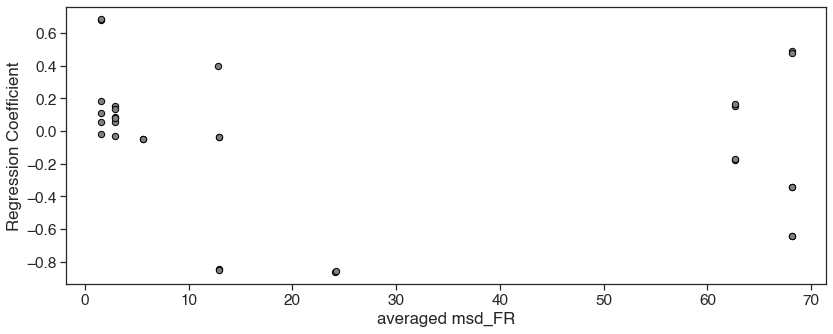

In [13]:
fig = plt.figure(figsize=(12,5))
plt.scatter(meanFR, coeff, s=40, c='gray', edgecolors=(0, 0, 0))
plt.xlabel("averaged msd_FR")
plt.ylabel("Regression Coefficient")
plt.tight_layout()


plt.show()
figName='linear_regression_scatter.png'
fig.savefig(figName, dpi=400)

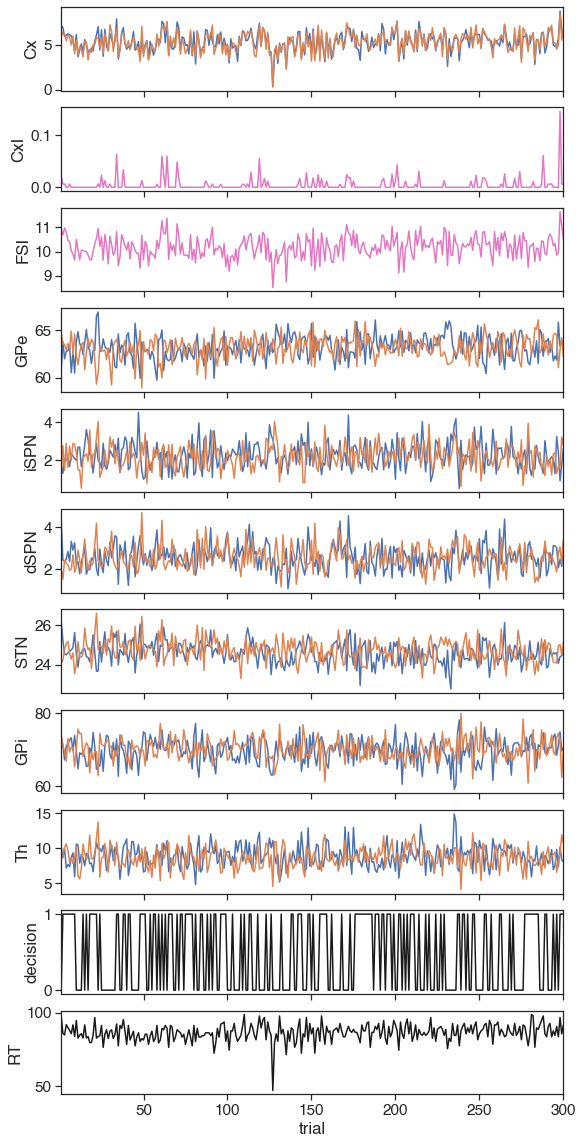

In [84]:
# load FR data
foldername="ControlCase"
(paramtable,datatables) = loadData("",foldername)
X=datatables[0].loc[datatables[0]['decision']!=None]

trials=list(range(1, 301))
f, ax = plt.subplots(11, 1, figsize=(9,20), sharex=True)

ax[0].plot(trials,X['msd_LIP_0_0'])
ax[0].plot(trials,X['msd_LIP_1_0'])
ax[0].set_ylabel('Cx')

ax[1].plot(trials,X['msd_LIPI_0'],color='tab:pink')
ax[1].set_ylabel('CxI')

ax[2].plot(trials,X['msd_FSI_0'],color='tab:pink')
ax[2].set_ylabel('FSI')

ax[3].plot(trials,X['msd_GPeP_0_0'])
ax[3].plot(trials,X['msd_GPeP_1_0'])
ax[3].set_ylabel('GPe')

ax[4].plot(trials,X['msd_D1STR_0_0'])
ax[4].plot(trials,X['msd_D1STR_1_0'])
ax[4].set_ylabel('iSPN')

ax[5].plot(trials,X['msd_D2STR_0_0'])
ax[5].plot(trials,X['msd_D2STR_1_0'])
ax[5].set_ylabel('dSPN')

ax[6].plot(trials,X['msd_STNE_0_0'])
ax[6].plot(trials,X['msd_STNE_1_0'])
ax[6].set_ylabel('STN')

ax[7].plot(trials,X['msd_GPi_0_0'])
ax[7].plot(trials,X['msd_GPi_1_0'])
ax[7].set_ylabel('GPi')

ax[8].plot(trials,X['msd_Th_0_0'])
ax[8].plot(trials,X['msd_Th_1_0'])
ax[8].set_ylabel('Th')

ax[9].plot(trials,X['decision'],color='k')
ax[9].set_ylabel('decision')

ax[10].plot(trials,X['decisionduration'],color='k')
ax[10].set_ylabel('RT')


plt.xlim(1,300)
plt.xlabel('trial')

plt.savefig('meanFR_all.png', dpi=400)

In [102]:
import statistics
Xb=datatables[0].loc[datatables[0]['decision']==1]
Xa=datatables[0].loc[datatables[0]['decision']==0]
Xr = pd.DataFrame(X,columns=['decisionduration','msd_FSI_0','msd_LIPI_0','msd_GPi_0_0','msd_GPi_1_0','msd_STNE_0_0','msd_STNE_1_0','msd_GPeP_0_0','msd_GPeP_1_0','msd_D1STR_0_0','msd_D1STR_1_0','msd_D2STR_0_0','msd_D2STR_1_0','msd_LIP_0_0','msd_LIP_1_0','msd_Th_0_0','msd_Th_1_0'])
for i in Xr:
    print(i,statistics.mean(Xr[i]))

decisionduration 86.45510416666667
msd_FSI_0 10.190203835169473
msd_LIPI_0 0.004567501743585277
msd_GPi_0_0 69.83005795796713
msd_GPi_1_0 70.19866874694824
msd_STNE_0_0 24.59900135676066
msd_STNE_1_0 24.711875400543214
msd_GPeP_0_0 63.241292241414385
msd_GPeP_1_0 63.17042263031006
msd_D1STR_0_0 2.2501959120233854
msd_D1STR_1_0 2.195939843853315
msd_D2STR_0_0 2.57556671222051
msd_D2STR_1_0 2.553072116772334
msd_LIP_0_0 5.299808426598708
msd_LIP_1_0 5.27939395258824
msd_Th_0_0 8.900661004384359
msd_Th_1_0 8.665416769981384


# C. HDDM results

(0.28, 0.4)

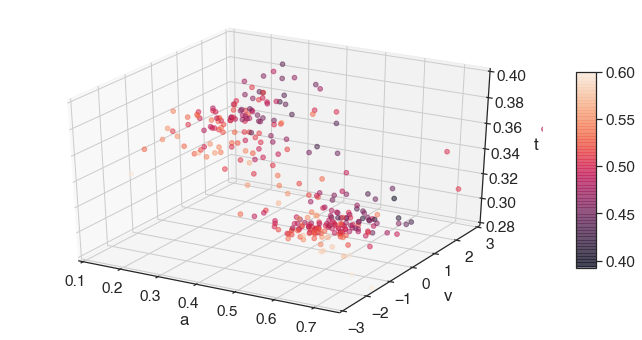

In [16]:
# 3D Scatter plot for te HDDM results: a-v-RT (with colormap = LD1-RD1 relation) 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams

fig = plt.figure(figsize=(12,6), facecolor='w')
ax = fig.gca(projection='3d')
xx=hddmSol.mean_a
yy=hddmSol.mean_v
zz=hddmSol.mean_t
cbar=hddmSol.mean_z

for i in range(0,np.size(cbar)):
    if cbar[i]>0.6:
        cbar[i]=0.6

name='HDDMoutput3Dcolor.png'


p=ax.scatter(xx, yy, zz, s=22, c=cbar, alpha=0.5)
fig.colorbar(p,shrink=0.6,aspect=10)


ax.set_xlabel('a')
ax.set_ylabel('v')
ax.set_zlabel('t')

ax.xaxis.labelpad=10
ax.yaxis.labelpad=10
ax.zaxis.labelpad=8

ax.set_xlim([0.1, 0.75])
ax.set_ylim([-3, 3])
ax.set_zlim([0.28, 0.4])


fig.savefig(name, dpi=400)

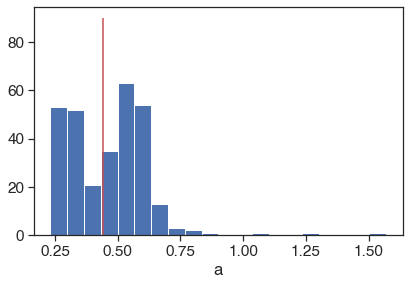

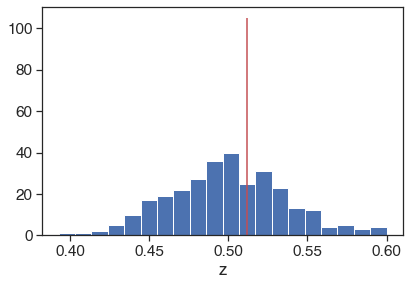

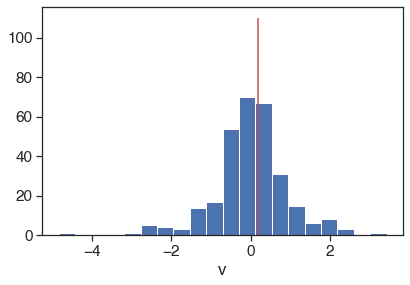

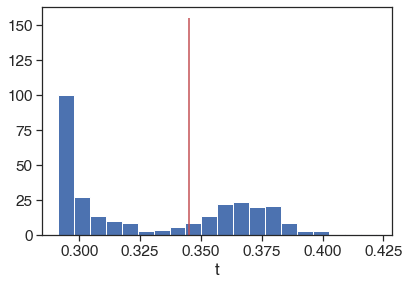

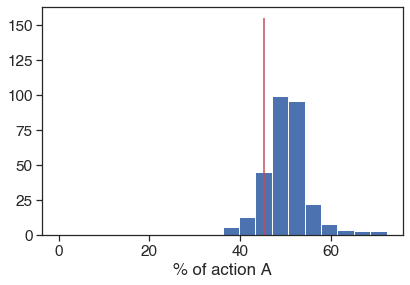

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
clrs = ['#347fff', '#febe08']
eclrs = ['#1657de', '#f5a005']

rc = {'font.family': u'sans-serif',
'font.sans-serif': [u'Helvetica',  u'Arial', u'sans-serif'],
'lines.solid_capstyle': u'butt'}
sns.set(style='ticks', font='Helvetica', rc=rc, font_scale=1.4)


# HDDM a-distribution
fig = plt.figure()
plt.hist(hddmSol.mean_a,20)
plt.vlines(hddmSolCC.mean_a,0,90,'r')
#plt.hist(abs(hddmSol.mean_a),20)
#plt.vlines(abs(hddmSolCC.mean_a),0,90,'r')
plt.tight_layout()
plt.xlabel("a")
fig.savefig('a_distribution.png', dpi=400)


# HDDM z-distribution
fig = plt.figure()
plt.hist(hddmSol.mean_z,20)
plt.vlines(hddmSolCC.mean_z,0,105,'r')
#plt.hist(abs(hddmSol.mean_z),20)
#plt.vlines(abs(hddmSolCC.mean_z),0,90,'r')
plt.tight_layout()
plt.xlabel("z")
fig.savefig('z_distribution.png', dpi=400)

# HDDM v-distribution
fig = plt.figure()
plt.hist(hddmSol.mean_v,20)
plt.vlines(hddmSolCC.mean_v,0,110,'r')
#plt.hist(abs(hddmSol.mean_v),20)
#plt.vlines(abs(hddmSolCC.mean_v),0,90,'r')
plt.tight_layout()
plt.xlabel("v")
fig.savefig('v_distribution.png', dpi=400)


# HDDM t-distribution
fig = plt.figure()
plt.hist(hddmSol.mean_t,20)
plt.vlines(hddmSolCC.mean_t,0,155,'r')
#plt.hist(abs(hddmSol.mean_t),20)
#plt.vlines(abs(hddmSolCC.mean_t),0,90,'r')
plt.tight_layout()
plt.xlabel("t")
fig.savefig('t_distribution.png', dpi=400)


# HDDM %Left-distribution
fig = plt.figure()
plt.hist(hddmSol.perc_L,20)
plt.vlines(hddmSolCC.perc_L,0,155,'r')
plt.tight_layout()
plt.xlabel("% of action A")
fig.savefig('Left_distribution.png', dpi=400)

# D. Clustering

In [17]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler



from sklearn.cluster import SpectralClustering

In [18]:
paramHDDM = pd.DataFrame(hddmSol,columns=['mean_a','mean_v','mean_t','mean_z'])

## (I) Normalize data as dRT/dx = (RT_plus - RT_minus)/2h 

In [19]:
paramHDDM = pd.DataFrame(hddmSol,columns=['mean_a','mean_v','mean_t','mean_z'])
a0=hddmSol.mean_a.mean()
v0=hddmSol.mean_v.mean()
t0=hddmSol.mean_t.mean()
z0=hddmSol.mean_z.mean()

dRT_da=0.10731435
dRT_dt=0.331168668776
dRT_dv=0.000266749999946
dRT_dz=-0.000320049997905

paramHDDM.mean_a = (paramHDDM.mean_a -  a0)*dRT_da
paramHDDM.mean_v = (paramHDDM.mean_v -  v0)*dRT_dv
paramHDDM.mean_t = (paramHDDM.mean_t -  t0)*dRT_dt
paramHDDM.mean_z = (paramHDDM.mean_z -  z0)*dRT_dz

## (II) K-means clustering

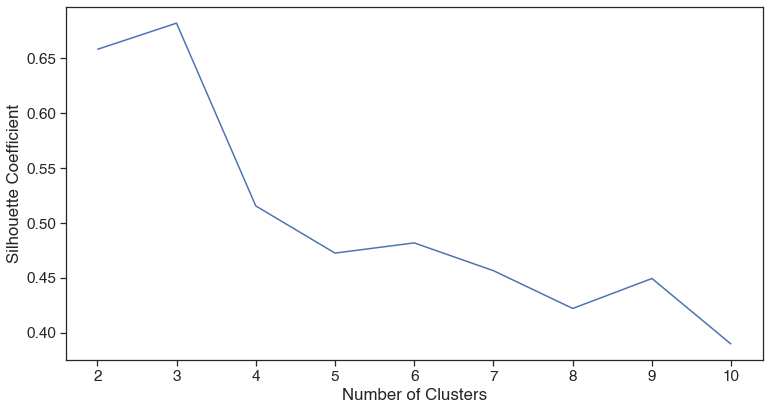

In [20]:
# HOW MANY CLUSTERS WE NEED?

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(paramHDDM)
    score = silhouette_score(paramHDDM, kmeans.labels_)
    silhouette_coefficients.append(score)
    
fig = plt.figure(figsize=(11,6), facecolor='w')
#plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.tight_layout()
plt.show()

name='Silhouette_coefficient'
fig.savefig(name, dpi=400)

0.68
kmeans labels: [0 1 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 1 0
 0 0 1 1 0 0 0 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 2 2 0 0 0 0 0 1 0 0 0 1 1
 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 2 1 1 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1
 0 1 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 1 1
 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 2 0 0 1 0 0 1 1
 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0
 0 1 1 1 0 0 0 1 0 0 1 1 0 0 1 2 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0
 1 0 0 1]


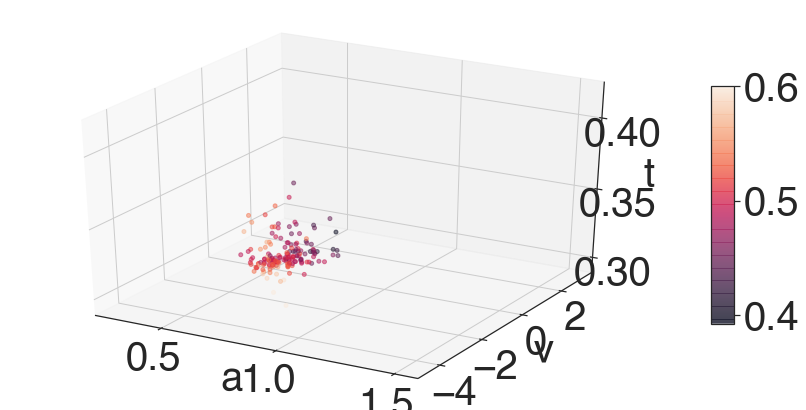

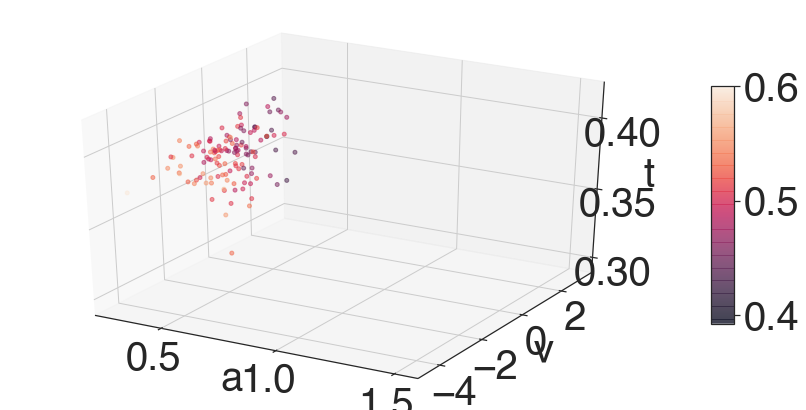

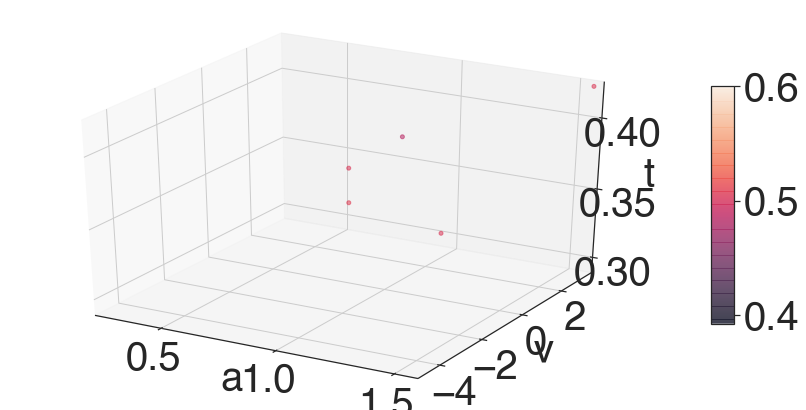

In [24]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(paramHDDM)

cas='k3_norm'

print(silhouette_score(paramHDDM, kmeans.labels_).round(2))

#scaler = MinMaxScaler()
#X_scaled = scaler.fit_transform(paramHDDM)
#kmeans.fit(X_scaled)
#print(silhouette_score(paramHDDM, kmeans.labels_).round(2))

print('kmeans labels:',kmeans.labels_)

column_names = ['mean_a','mean_t','mean_v','mean_z', 'perc_L', 'perc_R', 'rt', 'std_a','std_t','std_v','std_z','trial']
df0 = pd.DataFrame(columns = column_names)
df1 = pd.DataFrame(columns = column_names)
df2 = pd.DataFrame(columns = column_names)

j0=0
j1=0
j2=0
for i in range(0,len(kmeans.labels_)):
    if kmeans.labels_[i]==0:
        df0.loc[j0] = hddmSol.iloc[i]
        j0=j0+1
    if  kmeans.labels_[i]==1:
        df1.loc[j1] = hddmSol.iloc[i]
        j1=j1+1
    if  kmeans.labels_[i]==2:
        df2.loc[j2] = hddmSol.iloc[i]
        j2=j2+1

        # 3D Scatter plot for te HDDM results: a-v-RT (with colormap = LD1-RD1 relation) 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams

# PLOT DF0
fig = plt.figure(figsize=(12,6), facecolor='w')
ax = fig.gca(projection='3d')
xx=df0.mean_a
yy=df0.mean_v
zz=df0.mean_t
cbar=df0.mean_z

name='HDDMoutput3Dcolordf0_'+cas+'.png'

p=ax.scatter(xx, yy, zz, s=16, c=cbar, alpha=0.5,  vmin=min(hddmSol.mean_z), vmax=max(hddmSol.mean_z))
fig.colorbar(p,shrink=0.6,aspect=10)
ax.set_xlabel('a')
ax.set_ylabel('v')
ax.set_zlabel('t')

ax.xaxis.labelpad=10
ax.yaxis.labelpad=10
ax.zaxis.labelpad=8

ax.set_xlim(min(hddmSol.mean_a), max(hddmSol.mean_a))
ax.set_ylim(min(hddmSol.mean_v), max(hddmSol.mean_v))
ax.set_zlim(min(hddmSol.mean_t), max(hddmSol.mean_t))

plt.tight_layout()
fig.savefig(name, dpi=400)

# PLOT DF1
fig = plt.figure(figsize=(12,6), facecolor='w')
ax = fig.gca(projection='3d')
xx=df1.mean_a
yy=df1.mean_v
zz=df1.mean_t
cbar=df1.mean_z

name='HDDMoutput3Dcolordf1_'+cas+'.png'

p=ax.scatter(xx, yy, zz, s=16, c=cbar, alpha=0.5,  vmin=min(hddmSol.mean_z), vmax=max(hddmSol.mean_z))
fig.colorbar(p,shrink=0.6,aspect=10)
ax.set_xlabel('a')
ax.set_ylabel('v')
ax.set_zlabel('t')

ax.xaxis.labelpad=10
ax.yaxis.labelpad=10
ax.zaxis.labelpad=8


ax.set_xlim(min(hddmSol.mean_a), max(hddmSol.mean_a))
ax.set_ylim(min(hddmSol.mean_v), max(hddmSol.mean_v))
ax.set_zlim(min(hddmSol.mean_t), max(hddmSol.mean_t))

plt.tight_layout()
fig.savefig(name, dpi=400)

# PLOT DF2
fig = plt.figure(figsize=(12,6), facecolor='w')
ax = fig.gca(projection='3d')
xx=df2.mean_a
yy=df2.mean_v
zz=df2.mean_t
cbar=df2.mean_z

name='HDDMoutput3Dcolordf2_'+cas+'.png'

p=ax.scatter(xx, yy, zz, s=16, c=cbar, alpha=0.5,  vmin=min(hddmSol.mean_z), vmax=max(hddmSol.mean_z))
fig.colorbar(p,shrink=0.6,aspect=10)
ax.set_xlabel('a')
ax.set_ylabel('v')
ax.set_zlabel('t')

ax.xaxis.labelpad=10
ax.yaxis.labelpad=10
ax.zaxis.labelpad=8

ax.set_xlim(min(hddmSol.mean_a), max(hddmSol.mean_a))
ax.set_ylim(min(hddmSol.mean_v), max(hddmSol.mean_v))
ax.set_zlim(min(hddmSol.mean_t), max(hddmSol.mean_t))


plt.tight_layout()
fig.savefig(name, dpi=400)

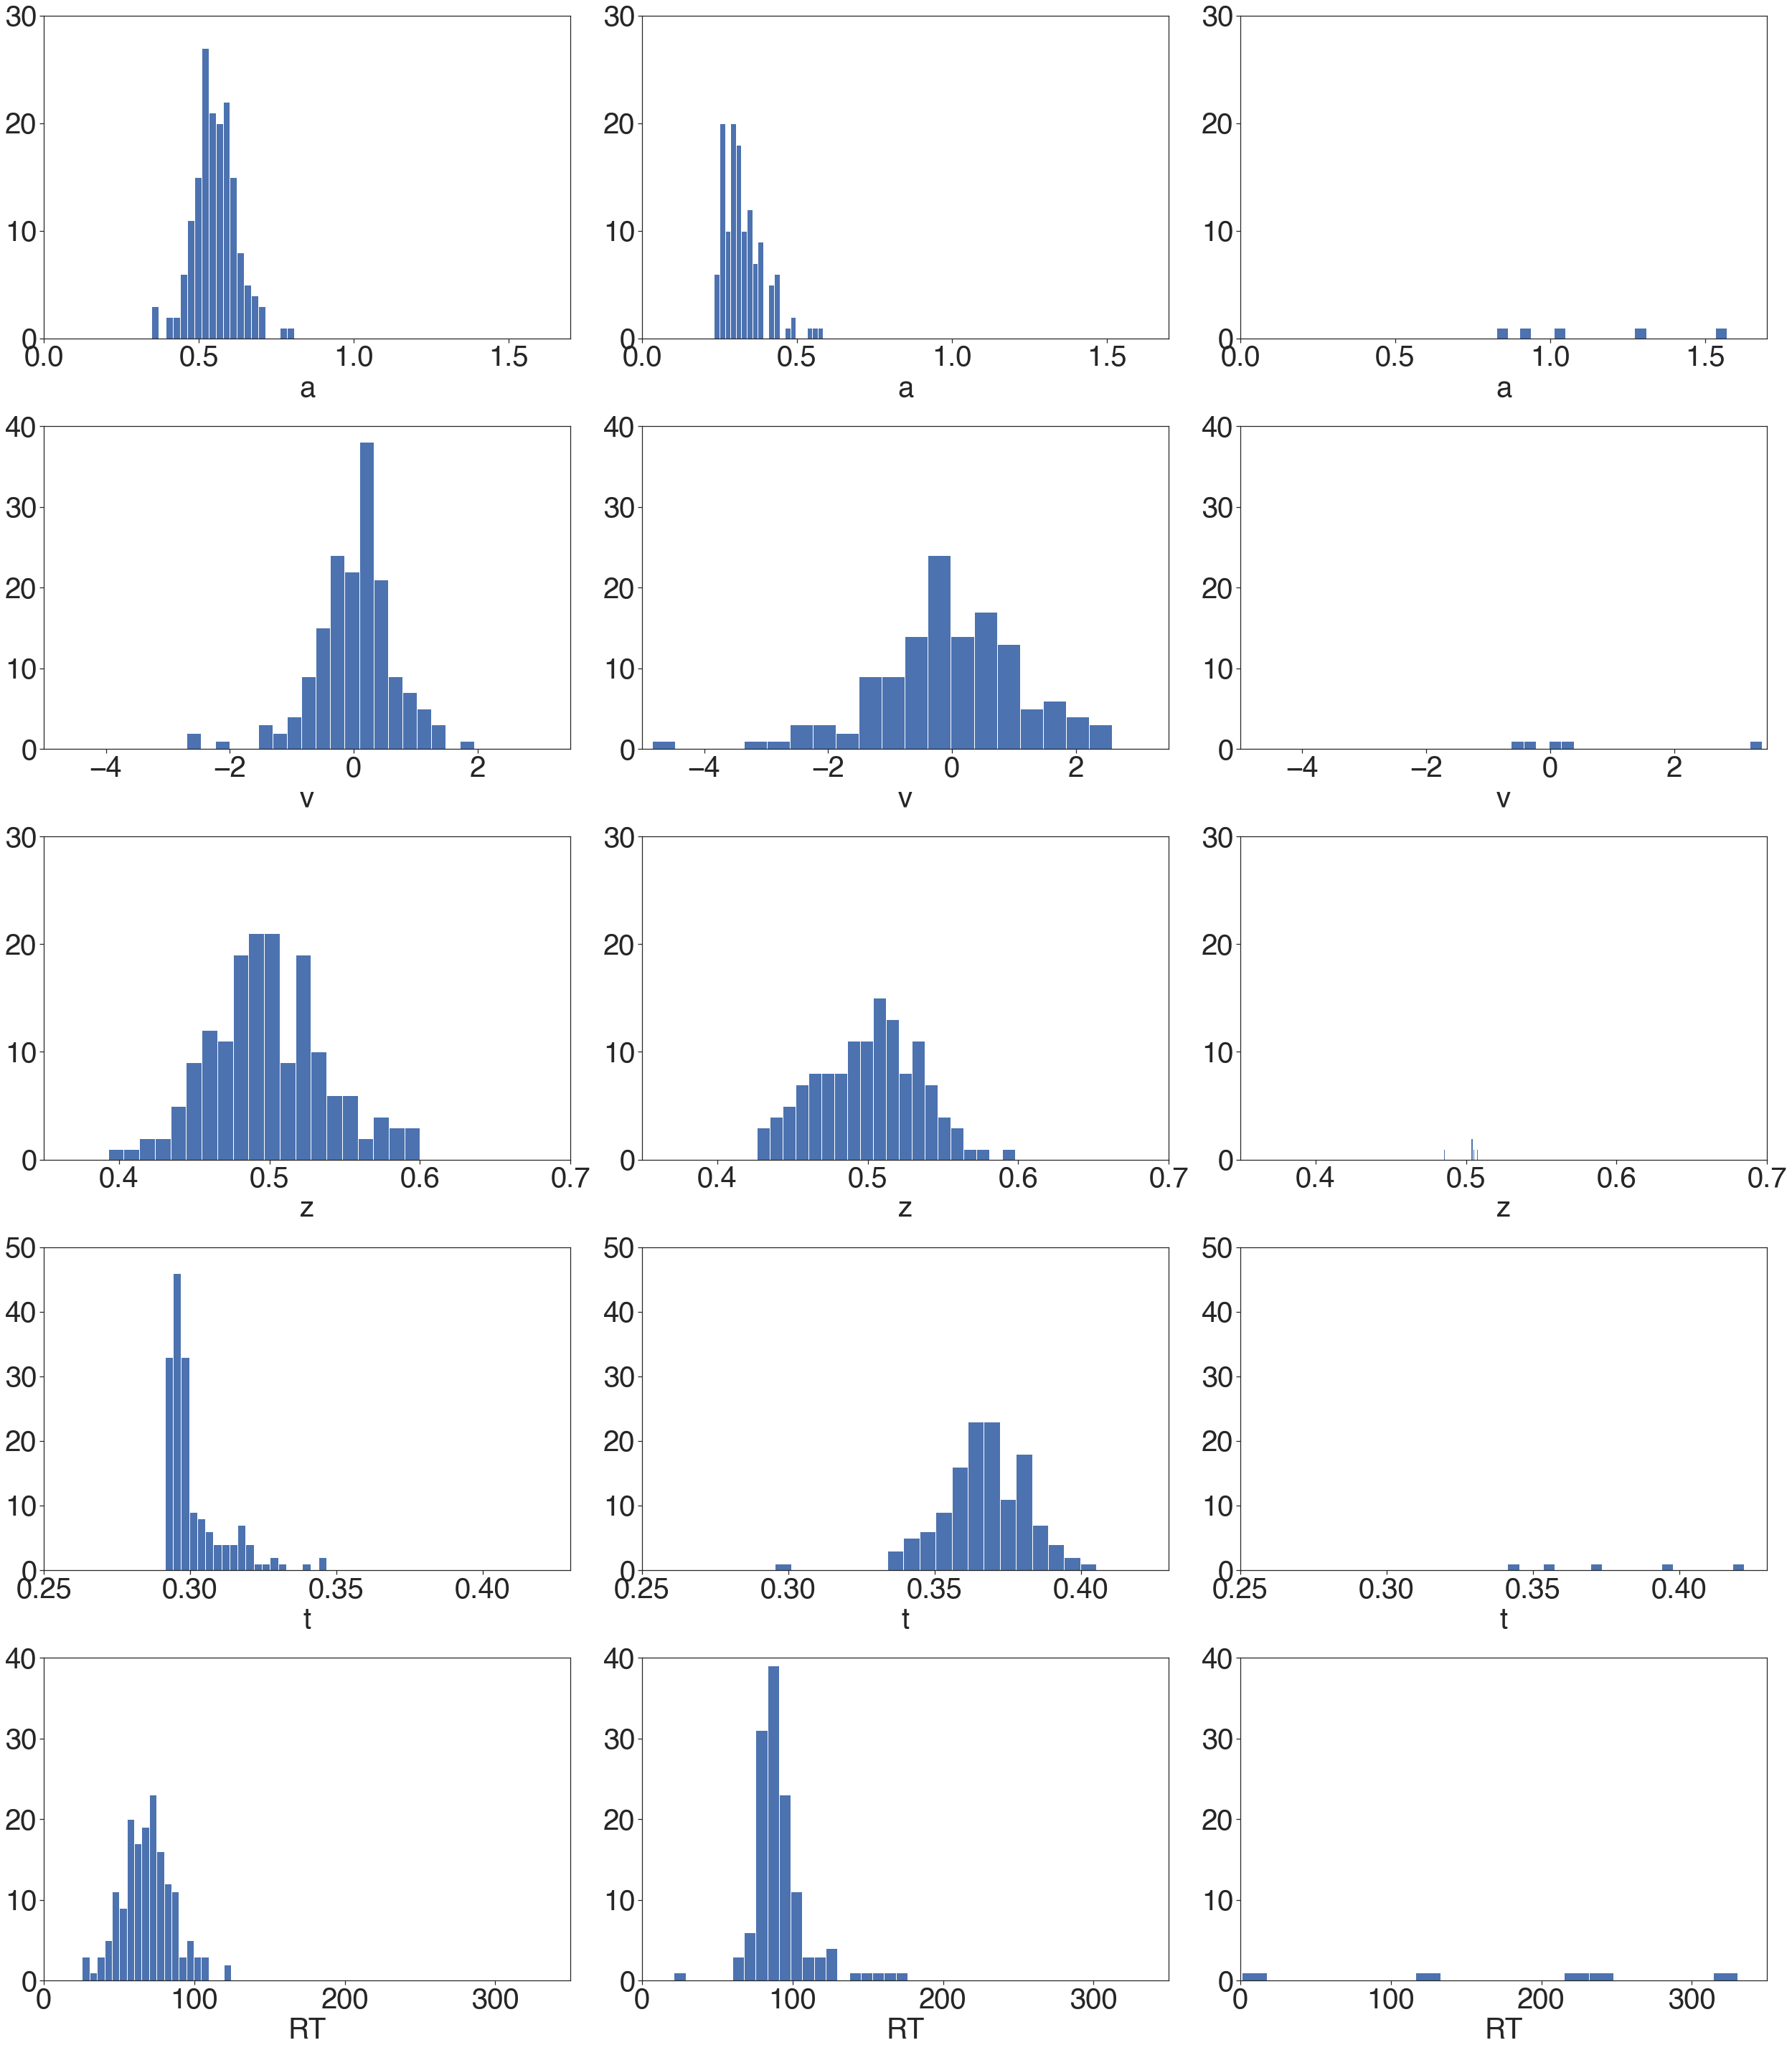

In [25]:
plt.rc('xtick', labelsize=40) 
plt.rc('ytick', labelsize=40) 
plt.rc('axes', labelsize=40) 

# Distributions
fig, axs = plt.subplots(5, 3, figsize=(35,40))


#Cx-MSN_NMDA + MSN_FR -- Th-STRd/i
axs[0, 0].hist(df0.mean_a,20)
axs[0, 0].set(xlabel='a')
axs[0, 1].hist(df1.mean_a,20)
axs[0, 1].set(xlabel='a')
axs[0, 2].hist(df2.mean_a,20)
axs[0, 2].set(xlabel='a')
axs[0, 0].set_ylim(0, 30)
axs[0, 1].set_ylim(0, 30)
axs[0, 2].set_ylim(0, 30)
axs[0, 0].set_xlim(0, 1.7)
axs[0, 1].set_xlim(0, 1.7)
axs[0, 2].set_xlim(0, 1.7)



axs[1, 0].hist(df0.mean_v,20)
axs[1, 0].set(xlabel='v')
axs[1, 1].hist(df1.mean_v,20)
axs[1, 1].set(xlabel='v')
axs[1, 2].hist(df2.mean_v,20)
axs[1, 2].set(xlabel='v')
axs[1, 0].set_ylim(0, 40)
axs[1, 1].set_ylim(0, 40)
axs[1, 2].set_ylim(0, 40)
axs[1, 0].set_xlim(-5., 3.5)
axs[1, 1].set_xlim(-5., 3.5)
axs[1, 2].set_xlim(-5., 3.5)

axs[2, 0].hist(df0.mean_z,20)
axs[2, 0].set(xlabel='z')
axs[2, 1].hist(df1.mean_z,20)
axs[2, 1].set(xlabel='z')
axs[2, 2].hist(df2.mean_z,20)
axs[2, 2].set(xlabel='z')
axs[2, 0].set_ylim(0, 30)
axs[2, 1].set_ylim(0, 30)
axs[2, 2].set_ylim(0, 30)
axs[2, 0].set_xlim(0.35, 0.7)
axs[2, 1].set_xlim(0.35, 0.7)
axs[2, 2].set_xlim(0.35, 0.7)


axs[3, 0].hist(df0.mean_t,20)
axs[3, 0].set(xlabel='t')
axs[3, 1].hist(df1.mean_t,20)
axs[3, 1].set(xlabel='t')
axs[3, 2].hist(df2.mean_t,20)
axs[3, 2].set(xlabel='t')
axs[3, 0].set_ylim(0, 50)
axs[3, 1].set_ylim(0, 50)
axs[3, 2].set_ylim(0, 50)
axs[3, 0].set_xlim(0.25, 0.43)
axs[3, 1].set_xlim(0.25, 0.43)
axs[3, 2].set_xlim(0.25, 0.43)

axs[4, 0].hist(df0.rt,20)
axs[4, 0].set(xlabel='RT')
axs[4, 1].hist(df1.rt,20)
axs[4, 1].set(xlabel='RT')
axs[4, 2].hist(df2.rt,20)
axs[4, 2].set(xlabel='RT')
axs[4, 0].set_ylim(0, 40)
axs[4, 1].set_ylim(0, 40)
axs[4, 2].set_ylim(0, 40)
axs[4, 0].set_xlim(0, 350)
axs[4, 1].set_xlim(0, 350)
axs[4, 2].set_xlim(0, 350)

plt.tight_layout()
fig.savefig('k3_distribution.png', dpi=400)

import matplotlib.pyplot as plt

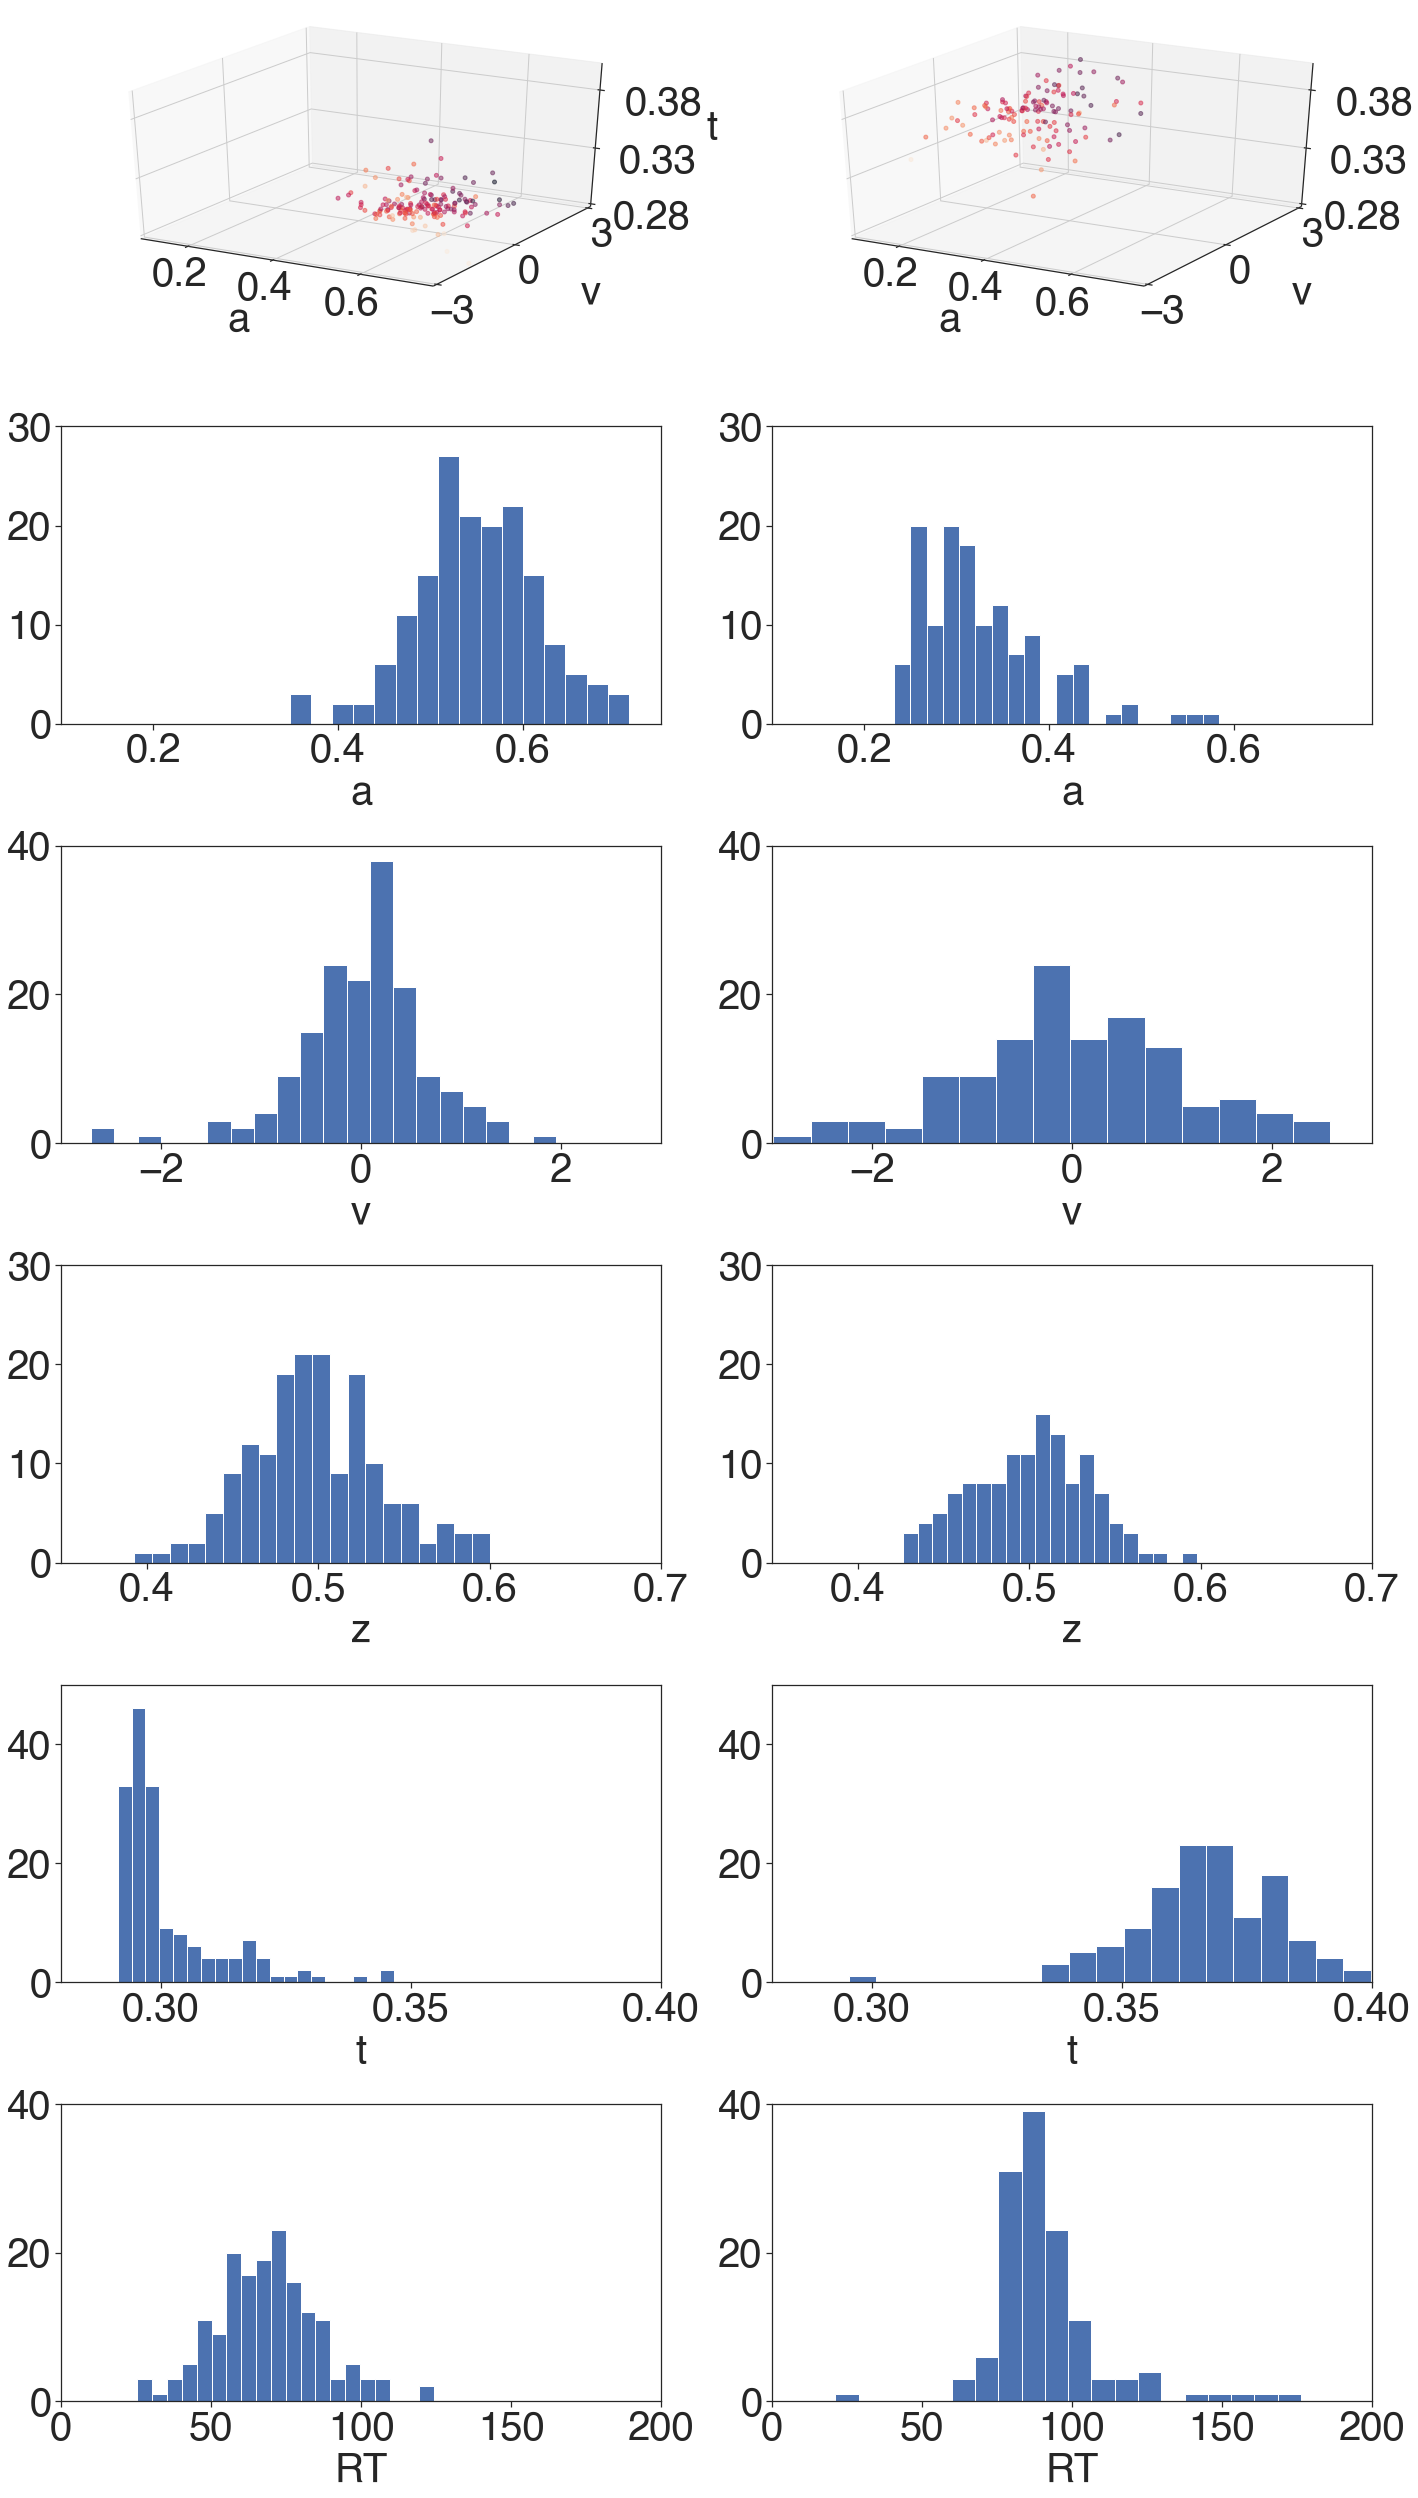

In [28]:
df2=df1
df1=df0

plt.rc('xtick', labelsize=40) 
plt.rc('ytick', labelsize=40) 
plt.rc('axes', labelsize=40) 

# Distributions
fig, axs = plt.subplots(6, 2, figsize=(20,35))

axs[0,0].axis('off')
axs[0,0] = fig.add_subplot(6, 2, 1, projection='3d')
axs[0,0].scatter(df1.mean_a, df1.mean_v, df1.mean_t, s=16, c=df1.mean_z, alpha=0.5,  vmin=min(hddmSol.mean_z), vmax=max(hddmSol.mean_z))

axs[0,0].tick_params(axis='z',pad=25)

axs[0,0].set_xlabel('a')
axs[0,0].set_ylabel('v')
axs[0,0].set_zlabel('t')

axs[0,0].xaxis.labelpad=40
axs[0,0].yaxis.labelpad=40
axs[0,0].zaxis.labelpad=40

axs[0,0].set_xlim(0.1, 0.75)
axs[0,0].set_ylim(-3,3)
axs[0,0].set_zlim(0.28, 0.40)

axs[0,0].set_yticks([-3, 0, 3])
axs[0,0].set_zticks([0.28, 0.33, 0.38])




axs[0,1].axis('off')
axs[0,1] = fig.add_subplot(6, 2, 2, projection='3d')
axs[0,1].scatter(df2.mean_a, df2.mean_v, df2.mean_t, s=16, c=df2.mean_z, alpha=0.5,  vmin=min(hddmSol.mean_z), vmax=max(hddmSol.mean_z))

axs[0,1].tick_params(axis='z',pad=25)

axs[0,1].set_xlabel('a')
axs[0,1].set_ylabel('v')
axs[0,1].set_zlabel('t')

axs[0,1].xaxis.labelpad=40
axs[0,1].yaxis.labelpad=40
axs[0,1].zaxis.labelpad=40

axs[0,1].set_xlim(0.1, 0.75)
axs[0,1].set_ylim(-3,3)
axs[0,1].set_zlim(0.28, 0.40)

axs[0,1].set_yticks([-3, 0, 3])
axs[0,1].set_zticks([0.28, 0.33, 0.38])

axs[1, 0].hist(df1.mean_a,20)
axs[1, 0].set(xlabel='a')
axs[1, 1].hist(df2.mean_a,20)
axs[1, 1].set(xlabel='a')
axs[1, 0].set_ylim(0, 30)
axs[1, 1].set_ylim(0, 30)
axs[1, 0].set_xlim(0.1, 0.75)
axs[1, 1].set_xlim(0.1, 0.75)


axs[2, 0].hist(df1.mean_v,20)
axs[2, 0].set(xlabel='v')
axs[2, 1].hist(df2.mean_v,20)
axs[2, 1].set(xlabel='v')
axs[2, 0].set_ylim(0, 40)
axs[2, 1].set_ylim(0, 40)
axs[2, 0].set_xlim(-3, 3)
axs[2, 1].set_xlim(-3, 3)

axs[3, 0].hist(df1.mean_z,20)
axs[3, 0].set(xlabel='z')
axs[3, 1].hist(df2.mean_z,20)
axs[3, 1].set(xlabel='z')
axs[3, 0].set_ylim(0, 30)
axs[3, 1].set_ylim(0, 30)
axs[3, 0].set_xlim(0.35, 0.7)
axs[3, 1].set_xlim(0.35, 0.7)


axs[4, 0].hist(df1.mean_t,20)
axs[4, 0].set(xlabel='t')
axs[4, 1].hist(df2.mean_t,20)
axs[4, 1].set(xlabel='t')
axs[4, 0].set_ylim(0, 50)
axs[4, 1].set_ylim(0, 50)
axs[4, 0].set_xlim(0.28, 0.4)
axs[4, 1].set_xlim(0.28, 0.4)

axs[5, 0].hist(df1.rt,20)
axs[5, 0].set(xlabel='RT')
axs[5, 1].hist(df2.rt,20)
axs[5, 1].set(xlabel='RT')
axs[5, 0].set_ylim(0, 40)
axs[5, 1].set_ylim(0, 40)
axs[5, 0].set_xlim(0, 200)
axs[5, 1].set_xlim(0, 200)

plt.tight_layout()
fig.savefig('k3_distribution-2col.png', dpi=400)

import matplotlib.pyplot as plt